# Przygotowanie środowiska
Import wymaganych bibliotek

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import ndcg_score

from keras.initializers import RandomNormal
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import optuna

2025-01-22 07:02:21.490939: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import własnych funkcji

In [2]:
from utils import *

# Dane

## Przedstawienie datasetu
W projekcie został użyty zbiór danych [MovieLens - ml-latest-small](https://grouplens.org/datasets/movielens/) który jest częstym wyborem do badań nad systemami rekomendacji  

Zawiera on onformacje o:
- 6,000 użytkownikach
- 9,000 filmach
- 100,000 opiniach

## Wczytanie danych

Dane zostały wstępnie obrobione, i zapisane w folderze `datasets`  
- Informacje dotyczące wstępnej obróbki datasetu znajdują się w pliku `./datasets/parse_datasets.ipynb`
- Informacje dotyczące sposobu załadowania danych znajdują się w pliku `./utils.py`

**Wczytanie danych**
- treningowych
- testowych
- listy urzytkowników
- listy itemów

In [3]:
train_data, test_data, users_all, items_all = load_dataset(dataset_path="./datasets/ml-latest-small")

for (label, data) in [["train_data",train_data],["test_data",test_data]]:
  print(f"{label}:")
  display(data)

train_dataset = to_dataset(train_data, batch_size=2048*5)

train_data:


,interaction,item_id,user_id
0,0,5481,447
1,1,3672,88
2,0,8711,211
3,0,8603,274
4,0,3819,602
...,...,...,...
1108570,1,1598,297
1108571,0,756,452
1108572,0,3852,90
1108573,0,5523,481


test_data:


,interaction,item_id,user_id
0,0,3051,380
1,0,5238,280
2,0,2308,199
3,0,5303,542
4,0,4682,607
...,...,...,...
61605,0,2495,523
61606,0,9235,487
61607,0,255,67
61608,0,1831,435


2025-01-22 07:02:23.107148: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-22 07:02:23.108197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-01-22 07:02:23.122311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-22 07:02:23.122446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.759GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2025-01-22 07:02:23.122471: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-01-22 07:02:23.123834: I tensorflow/stream_executor/platfor

In [4]:
def create_model_MF(num_users, num_items, latent_dim, embeding_l2 = 0):
  user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
  item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

  MF_Embedding_User = Embedding(
    input_dim = num_users, output_dim = latent_dim, 
    name = 'user_embedding',
    embeddings_initializer="RandomNormal", embeddings_regularizer = l2(embeding_l2), 
    input_length=1
  )
  MF_Embedding_Item = Embedding(
    input_dim = num_items, output_dim = latent_dim, 
    name = 'item_embedding',
    embeddings_initializer="RandomNormal", embeddings_regularizer = l2(embeding_l2), 
    input_length=1
  )   
  
  user_latent = Flatten()(MF_Embedding_User(user_input))
  item_latent = Flatten()(MF_Embedding_Item(item_input))
  
  predict_vector = Multiply(name="GMF_Layer")([user_latent, item_latent])
  prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
  
  return Model(inputs=[user_input, item_input], outputs=prediction)

# Utworzenie modelu oraz jego szkolenie

## Teoria
Podstawę do budowania modelu stanowi praca [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031) z 2017 roku, która przedstawia sposób przeprowadzenia faktoryzacji macierzy z udziałem sieci neuronowej (NeuMF - Neural matrix factorization).

Implementacja sieci NeuFM oparta o Keras (stworzona przez autora He Xiangnan) znajduje się [tutaj](https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/NeuMF.py)

Autorzy proponują poniższy model:  
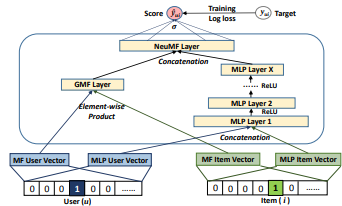




## Funkcja generująca model
### Działanie:
`user`, `item` warstwy wejściowe  

`create_mlp(user, item)`   
    tworzy MLP_User_Vector oraz MLP_Item_Vector i przekazuje je do MLP  
	zwraca MLP  

`create_gmf(user, item)`  
	tworzy MF_User_Vector oraz MF_Item_Vector i przekazuje je do warstwy GMF_Layer która wykonuje mnorzenie macierzy  
	zwraca GMF_Layer  


następnie wyniki `create_mlp(user, item)` i `create_gmf(user, item)` są łączone i przekazywane do warstwy gęstej której wyjście jest wyjściem modelu

### Implementacja:

In [5]:
def create_model_NeuMF(p):
  layers_mlp=[{"neurons":p["mlp_layers_neurons"]*2**x, "l2":p["mlp_l2"]} for x in range(p["mlp_layers_num"])]
  layers_mlp.reverse()
    
  def create_mlp(user, item):
    mlp_user_embedding = Embedding(
      input_dim=p["n_users"], output_dim=p["latent_dim_mlp"],
      name="MLP_User_Embedding",
      embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2_mlp"]),
      input_length=1,
    )
    
    mlp_item_embedding = Embedding(
      input_dim=p["n_items"], output_dim=p["latent_dim_mlp"],
      name="MLP_Item_Embedding",
      embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2_mlp"]),
      input_length=1,
    )
    
    mlp_user_vector = Flatten(name="MLP_User_Vector")(mlp_user_embedding(user))
    mlp_item_vector = Flatten(name="MLP_Item_Vector")(mlp_item_embedding(item))

    mlp_vector = Concatenate(name="MLP_Concatenation")([mlp_user_vector, mlp_item_vector])
    
    for i in range(len(layers_mlp)):
      layer = Dense(
        layers_mlp[i]["neurons"],
        activity_regularizer=l2(layers_mlp[i]["l2"]),
        activation="relu",
        name=f"MLP_Layer_{i+1}",
      )
      mlp_vector = layer(mlp_vector)
        
    return mlp_vector
  
  def create_gmf(user, item):
    mf_user_embedding = Embedding(
      input_dim=p["n_users"],
      output_dim=p["latent_dim_mf"],
      name="MF_User_Embedding",
      embeddings_initializer="RandomNormal",
      embeddings_regularizer=l2(p["embeding_l2_mf"]),
      input_length=1,
    )
    
    mf_item_embedding = Embedding(
      input_dim=p["n_items"],
      output_dim=p["latent_dim_mf"],
      name="MF_Item_Embedding",
      embeddings_initializer="RandomNormal",
      embeddings_regularizer=l2(p["embeding_l2_mf"]),
      input_length=1,
    )

    mf_user_vector = Flatten(name="MF_User_Vector")(mf_user_embedding(user))
    mf_item_vector = Flatten(name="MS_Item_Vector")(mf_item_embedding(item))
    
    return Multiply(name="GMF_Layer")([mf_user_vector, mf_item_vector])

  user = Input(shape=(), dtype="int32", name="user_id")
  item = Input(shape=(), dtype="int32", name="item_id")

  neumf_layer = Concatenate(name="NeuMF_Layer")([create_gmf(user, item), create_mlp(user, item)])
  output = Dense(1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction")(neumf_layer)

  return Model(inputs=[user, item], outputs=[output])

## Kompilacja i tuningowanie
Tunowanie modelu przebiega z urzyciem biblioteki `optuna`. Staramy się zmaksymalizować metrykę `NDGC@10`.

Model został tuningowany pod poniższymi parametrami:
- `latent_dim_mf` - ilość wymiarów embeddingu części GMF
- `latent_dim_mlp` - ilość wymiarów embeddingu części MLP
- `embeding_l2_mf` - stopień regularyzacji `l2` urzyty dla embeddingu w GMF
- `embeding_l2_mlp` - stopień regularyzacji `l2` urzyty dla embeddingu w MLP
- `mlp_layers_num` - liczba warstw MLP
- `mlp_layers_neurons` - liczba neuronów w najmniejszej warstwie MLP
- `mlp_l2` - stopień regularyzacji `l2` urzyty dla warstw w MLP


Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

In [12]:
from optuna.storages import RDBStorage

storage = RDBStorage("sqlite:///op.db")


[I 2025-01-22 07:17:25,227] A new study created in RDB with name: no-name-1d2d2b60-c473-444b-a667-dd699a3655d1
  0%|          | 0/20 [00:00<?, ?it/s]2025-01-22 07:17:25.658840: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:17:25.658865: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:17:25.658904: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:17:25.658918: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:17:27.540040: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:17:27.540070: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:17:27.540115: E tensorflow/core/profiler/internal

2025-01-22 07:17:27.700920: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:17:27.734555: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:17:27.748968: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:17:27.824670: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-071725/train/plugins/profile/2025_01_22_07_17_27
2025-01-22 07:17:27.874300: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-071725/train/plugins/profile/2025_01_22_07_17_27/computer.trace.json.gz
2025-01-22 07:17:27.921515: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-071725/train/plugins/profile/2025_01_22_07_17_27
2025-01-22 07:17:27.924383: I tensorflow/core/pro

Epoch 14: Early stopping triggered.


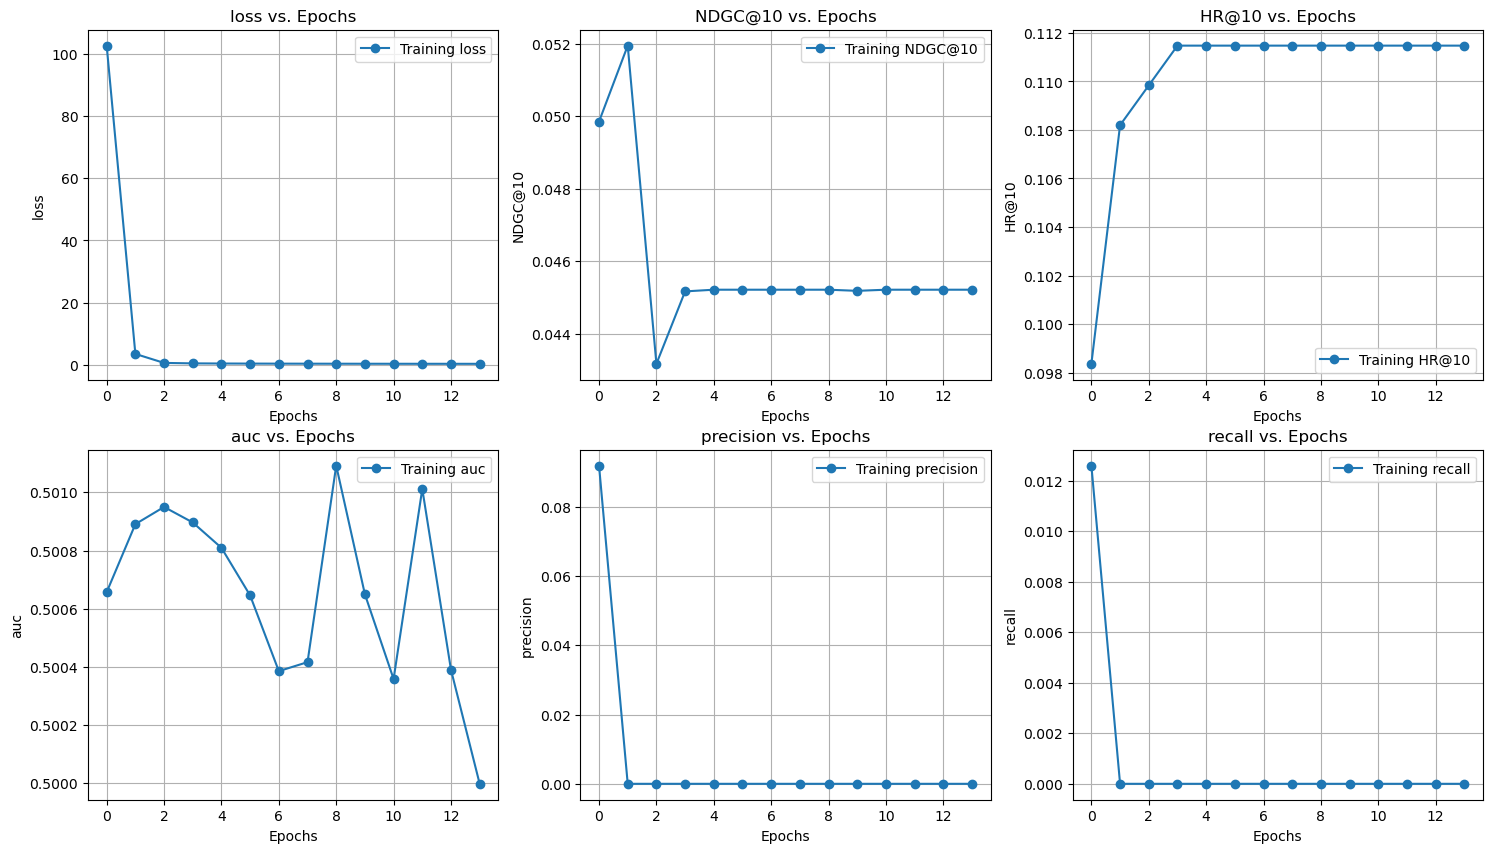

Best trial: 0. Best value: 0.0452112:   5%|▌         | 1/20 [01:23<26:28, 83.58s/it]

[I 2025-01-22 07:18:48,775] Trial 0 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 104, 'latent_dim_mlp': 80, 'embeding_l2_mf': 0.09032847321502442, 'embeding_l2_mlp': 0.0628943278754766, 'mlp_layers_num': 8, 'mlp_layers_neurons': 6, 'mlp_l2': 0.05211749867290649}. Best is trial 0 with value: 0.045211244674430655.


2025-01-22 07:18:49.278583: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:18:49.278617: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:18:49.278665: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:18:49.278690: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:18:51.337049: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:18:51.337081: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:18:51.337131: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:18:51.520878: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:18:51.561119: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:18:51.577775: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:18:51.668087: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-071849/train/plugins/profile/2025_01_22_07_18_51
2025-01-22 07:18:51.724707: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-071849/train/plugins/profile/2025_01_22_07_18_51/computer.trace.json.gz
2025-01-22 07:18:51.773394: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-071849/train/plugins/profile/2025_01_22_07_18_51
2025-01-22 07:18:51.778597: I tensorflow/core/pro

Epoch 13: Early stopping triggered.


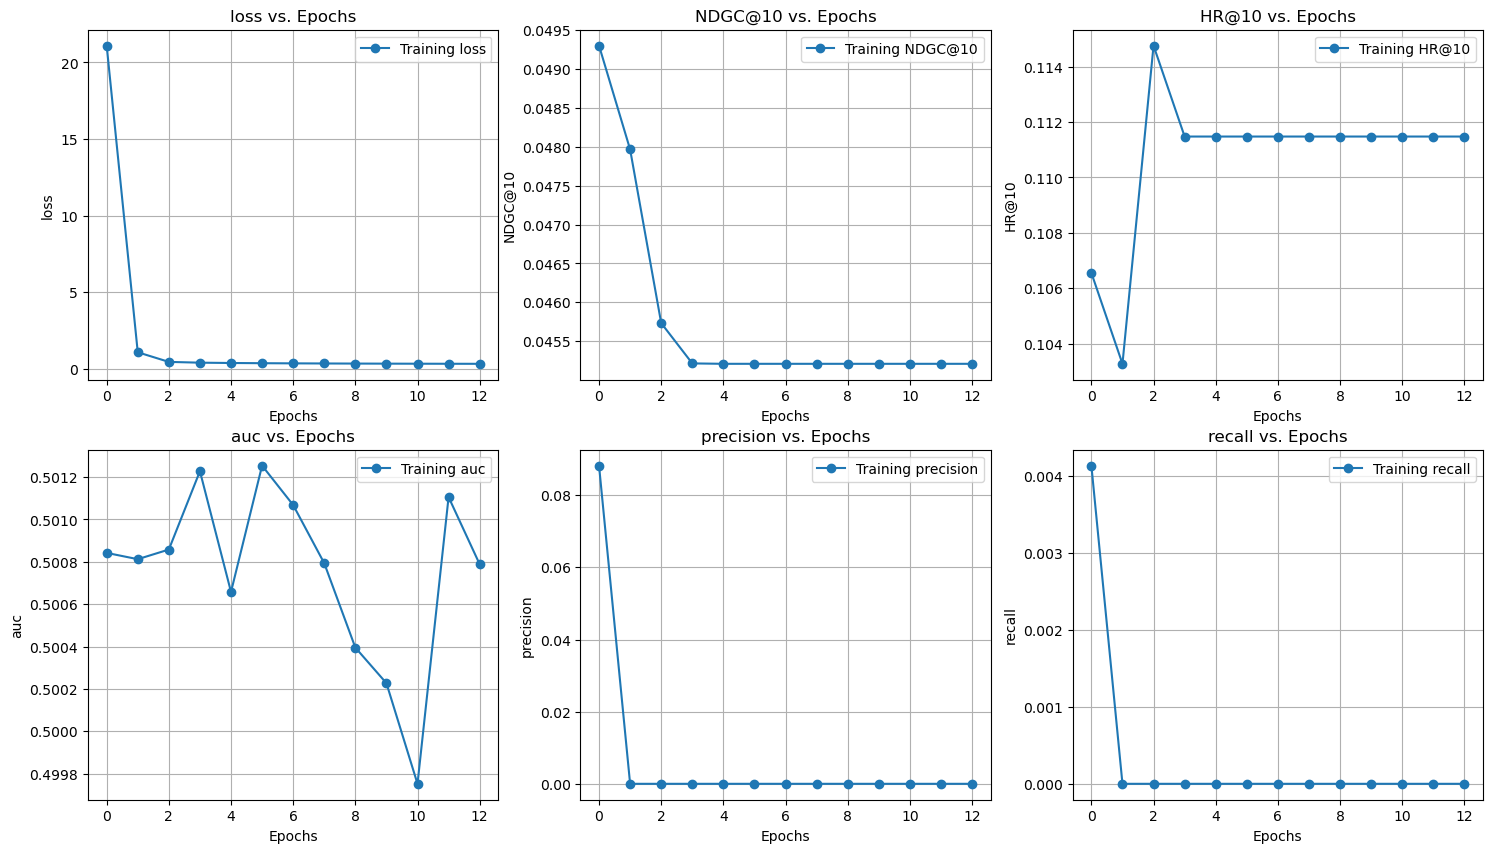

Best trial: 0. Best value: 0.0452112:  10%|█         | 2/20 [02:42<24:16, 80.91s/it]

[I 2025-01-22 07:20:07,835] Trial 1 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 119, 'latent_dim_mlp': 94, 'embeding_l2_mf': 0.00783741725198236, 'embeding_l2_mlp': 0.020909332791717174, 'mlp_layers_num': 7, 'mlp_layers_neurons': 11, 'mlp_l2': 0.04087579094256854}. Best is trial 0 with value: 0.045211244674430655.


2025-01-22 07:20:08.240619: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:20:08.240649: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:20:08.240704: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:20:08.240723: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:20:10.897110: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:20:10.897144: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:20:10.897194: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:20:11.065503: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:20:11.105410: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:20:11.123605: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:20:11.213743: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072008/train/plugins/profile/2025_01_22_07_20_11
2025-01-22 07:20:11.271531: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072008/train/plugins/profile/2025_01_22_07_20_11/computer.trace.json.gz
2025-01-22 07:20:11.322255: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072008/train/plugins/profile/2025_01_22_07_20_11
2025-01-22 07:20:11.328582: I tensorflow/core/pro

Epoch 13: Early stopping triggered.


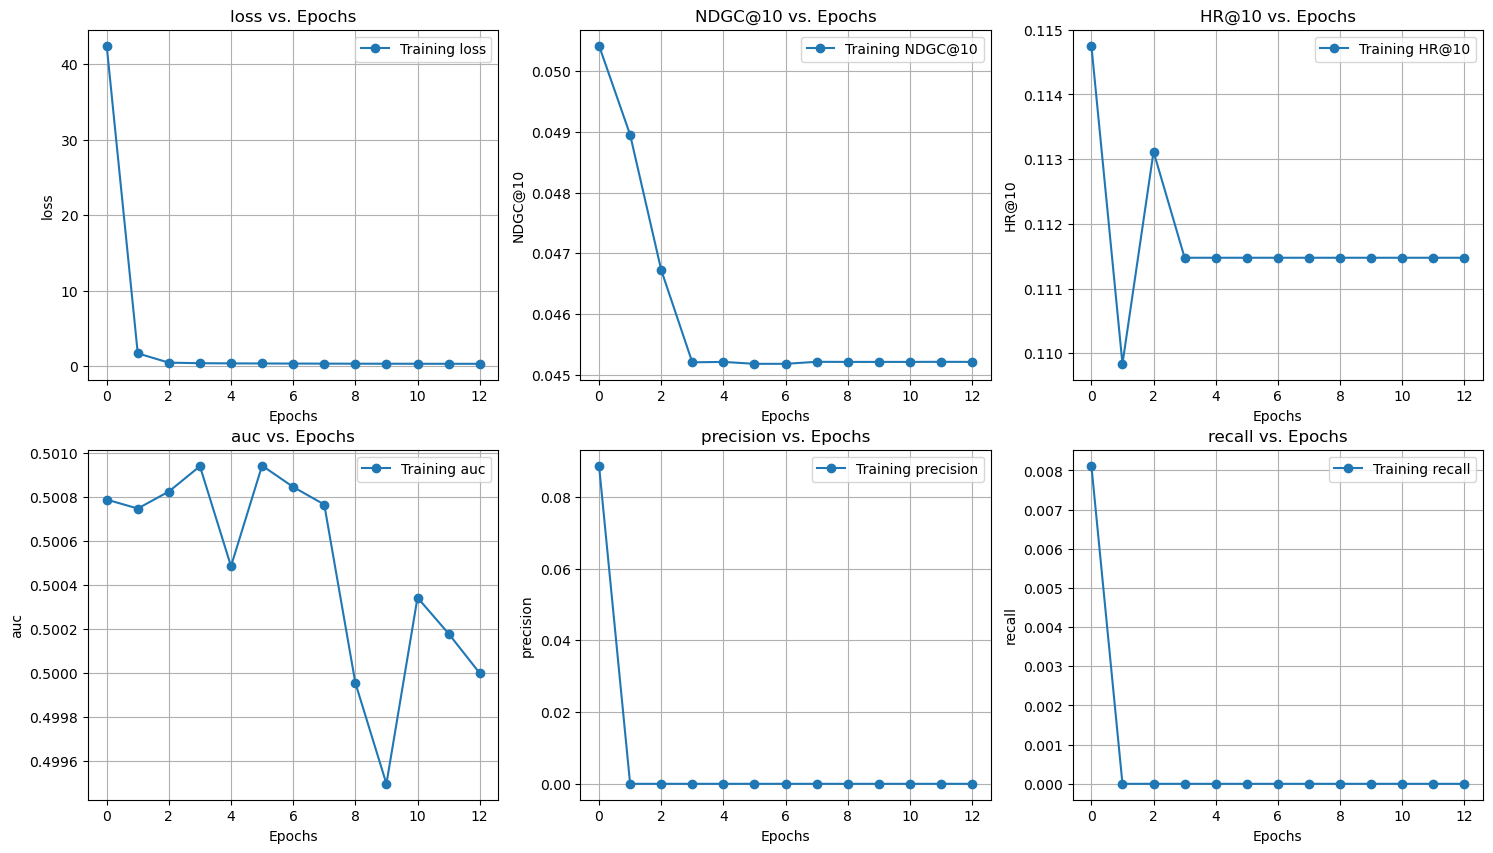

Best trial: 0. Best value: 0.0452112:  15%|█▌        | 3/20 [03:54<21:46, 76.88s/it]

[I 2025-01-22 07:21:19,910] Trial 2 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 105, 'latent_dim_mlp': 114, 'embeding_l2_mf': 0.01658451741068089, 'embeding_l2_mlp': 0.03663917178879267, 'mlp_layers_num': 6, 'mlp_layers_neurons': 14, 'mlp_l2': 0.06724990945556801}. Best is trial 0 with value: 0.045211244674430655.


2025-01-22 07:21:20.408531: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:21:20.408561: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:21:20.408607: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:21:20.408624: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:21:22.611143: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:21:22.611176: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:21:22.611227: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:21:22.796134: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:21:22.812485: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:21:22.901944: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072120/train/plugins/profile/2025_01_22_07_21_22
2025-01-22 07:21:22.960663: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072120/train/plugins/profile/2025_01_22_07_21_22/computer.trace.json.gz
2025-01-22 07:21:23.010246: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072120/train/plugins/profile/2025_01_22_07_21_22
2025-01-22 07:21:23.013480: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/20250122-072120/tra

Epoch 13: Early stopping triggered.


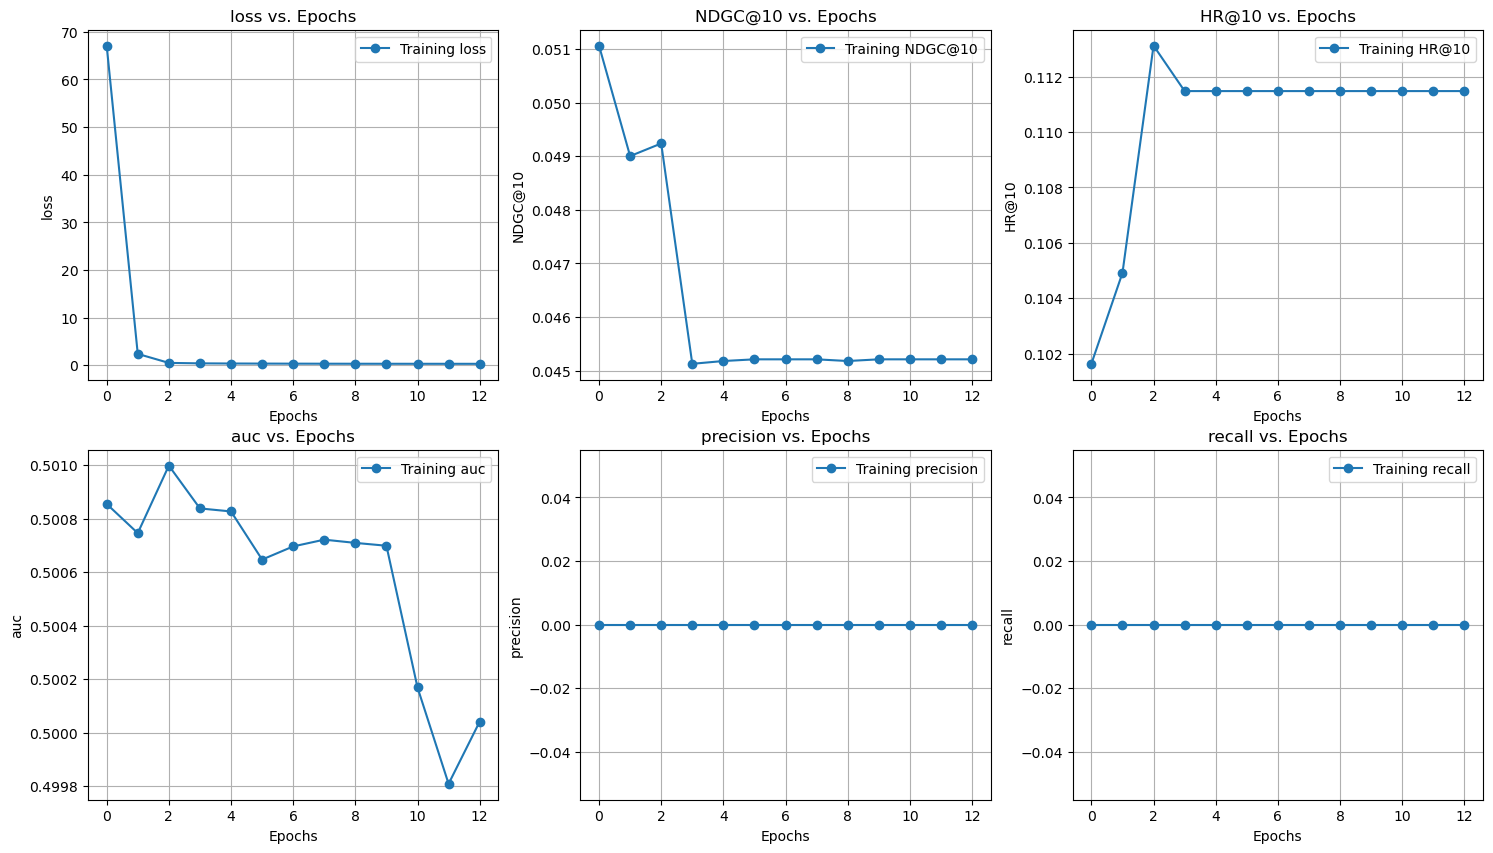

Best trial: 0. Best value: 0.0452112:  20%|██        | 4/20 [04:52<18:29, 69.36s/it]

[I 2025-01-22 07:22:17,761] Trial 3 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 88, 'latent_dim_mlp': 36, 'embeding_l2_mf': 0.06996104152699453, 'embeding_l2_mlp': 0.09094124753231542, 'mlp_layers_num': 5, 'mlp_layers_neurons': 13, 'mlp_l2': 0.08398909423519765}. Best is trial 0 with value: 0.045211244674430655.


2025-01-22 07:22:18.134337: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:22:18.134374: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:22:18.134447: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:22:18.134470: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:22:19.817756: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:22:19.817809: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:22:19.817874: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:22:19.951792: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:22:19.991176: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:22:20.007763: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:22:20.096634: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072218/train/plugins/profile/2025_01_22_07_22_20
2025-01-22 07:22:20.155952: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072218/train/plugins/profile/2025_01_22_07_22_20/computer.trace.json.gz
2025-01-22 07:22:20.200804: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072218/train/plugins/profile/2025_01_22_07_22_20
2025-01-22 07:22:20.204423: I tensorflow/core/pro

Epoch 15: Early stopping triggered.


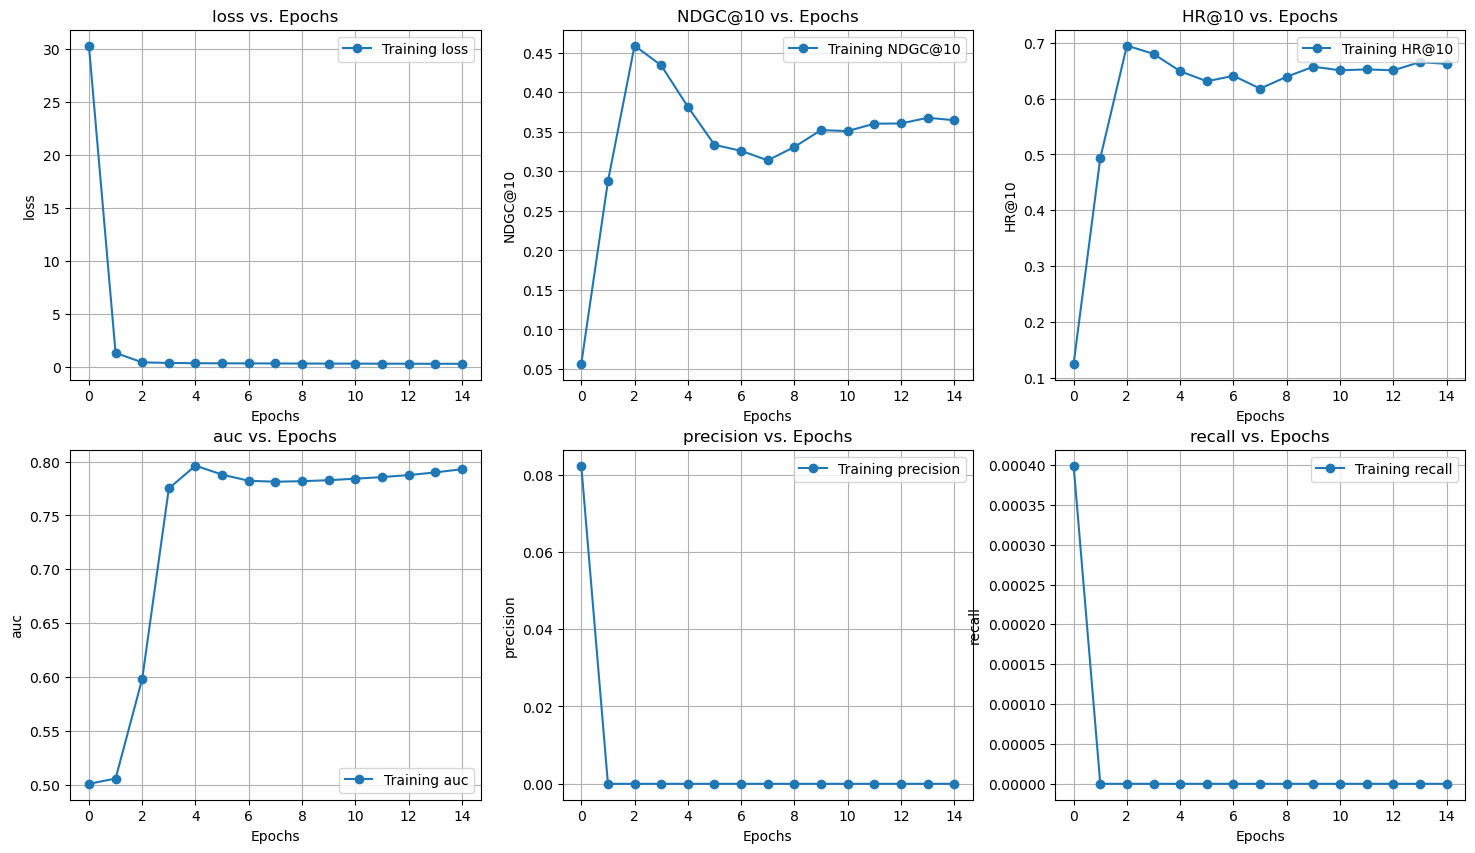

Best trial: 4. Best value: 0.364703:  25%|██▌       | 5/20 [06:01<17:18, 69.21s/it] 

[I 2025-01-22 07:23:26,683] Trial 4 finished with value: 0.36470297310344835 and parameters: {'latent_dim_mf': 109, 'latent_dim_mlp': 67, 'embeding_l2_mf': 0.011788138882660072, 'embeding_l2_mlp': 0.04343446495965497, 'mlp_layers_num': 2, 'mlp_layers_neurons': 6, 'mlp_l2': 0.04417627882196216}. Best is trial 4 with value: 0.36470297310344835.


2025-01-22 07:23:27.209209: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:23:27.209243: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:23:27.209295: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:23:27.209315: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:23:29.090831: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:23:29.090861: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:23:29.090909: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:23:29.228773: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:23:29.264767: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:23:29.279746: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:23:29.369424: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072327/train/plugins/profile/2025_01_22_07_23_29
2025-01-22 07:23:29.426262: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072327/train/plugins/profile/2025_01_22_07_23_29/computer.trace.json.gz
2025-01-22 07:23:29.472167: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072327/train/plugins/profile/2025_01_22_07_23_29
2025-01-22 07:23:29.475853: I tensorflow/core/pro

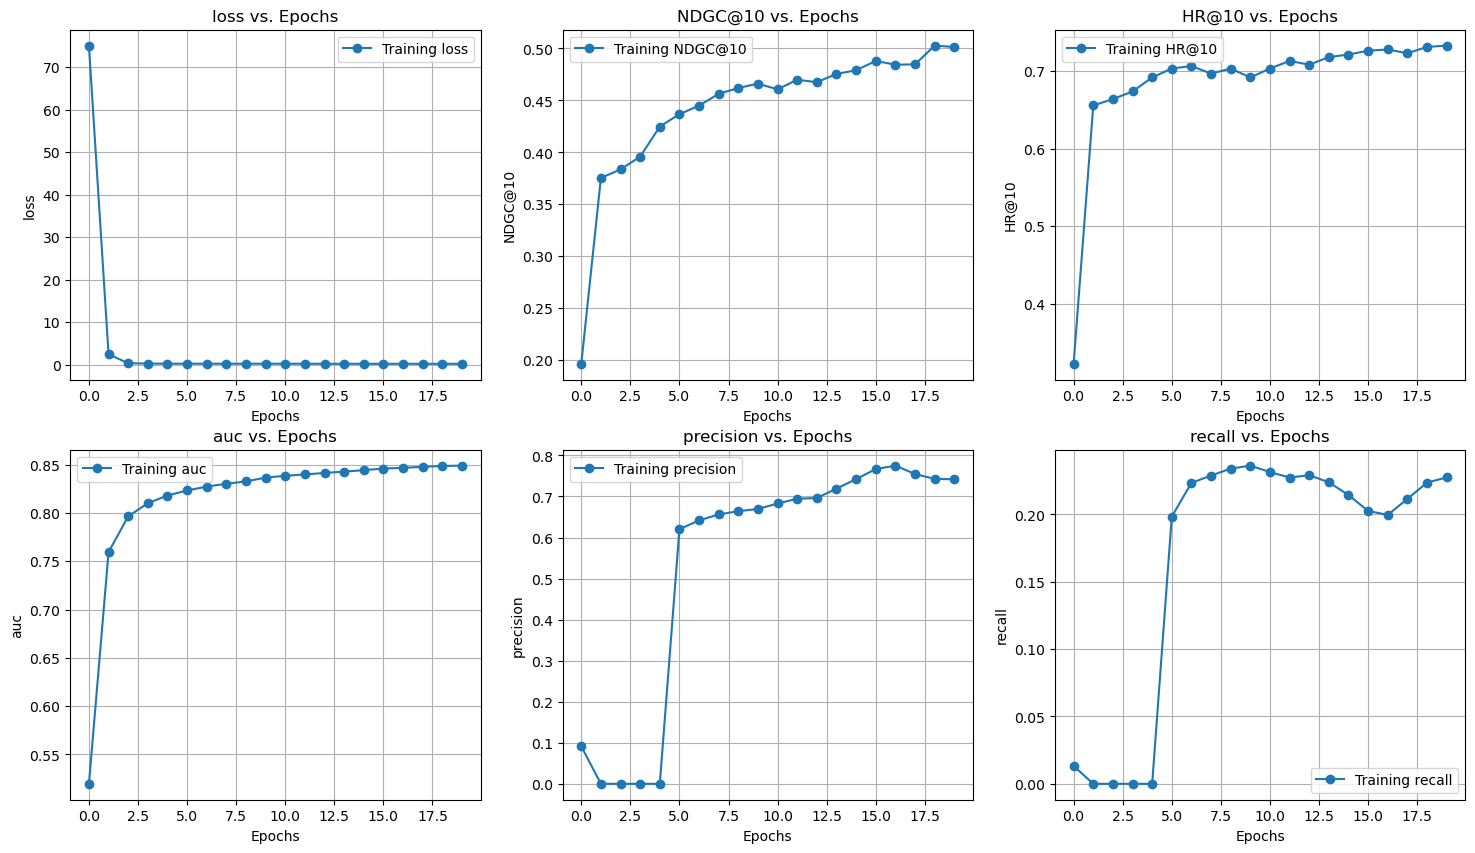

Best trial: 5. Best value: 0.501423:  30%|███       | 6/20 [08:11<21:00, 90.04s/it]

[I 2025-01-22 07:25:37,158] Trial 5 finished with value: 0.5014232784253373 and parameters: {'latent_dim_mf': 124, 'latent_dim_mlp': 121, 'embeding_l2_mf': 0.006584317816891461, 'embeding_l2_mlp': 0.08018268188409927, 'mlp_layers_num': 4, 'mlp_layers_neurons': 30, 'mlp_l2': 0.006728287940123878}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:25:37.702045: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:25:37.702079: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:25:37.702140: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:25:37.702161: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:25:40.291335: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:25:40.291371: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:25:40.291428: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:25:40.473476: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:25:40.521779: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:25:40.546729: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:25:40.658223: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072537/train/plugins/profile/2025_01_22_07_25_40
2025-01-22 07:25:40.731913: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072537/train/plugins/profile/2025_01_22_07_25_40/computer.trace.json.gz
2025-01-22 07:25:40.792270: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072537/train/plugins/profile/2025_01_22_07_25_40
2025-01-22 07:25:40.800410: I tensorflow/core/pro

Epoch 14: Early stopping triggered.


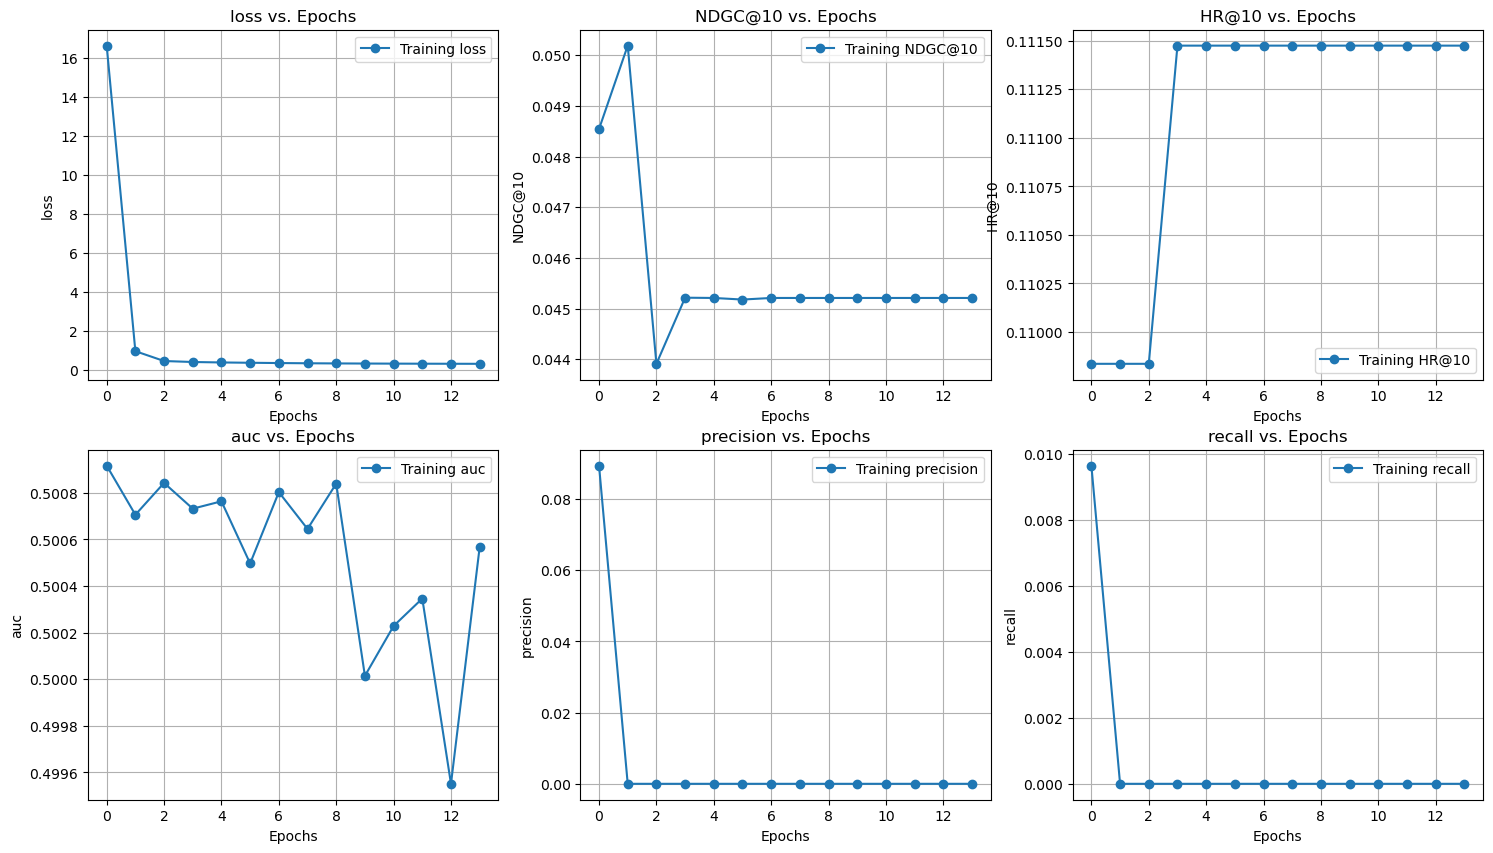

Best trial: 5. Best value: 0.501423:  35%|███▌      | 7/20 [09:22<18:07, 83.63s/it]

[I 2025-01-22 07:26:47,584] Trial 6 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 61, 'latent_dim_mlp': 24, 'embeding_l2_mf': 0.022814529869463664, 'embeding_l2_mlp': 0.03659047332139718, 'mlp_layers_num': 4, 'mlp_layers_neurons': 13, 'mlp_l2': 0.07923496262508212}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:26:47.996065: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:26:47.996097: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:26:47.996148: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:26:47.996168: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:26:50.579888: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:26:50.579927: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:26:50.579982: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:26:50.752163: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:26:50.801018: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:26:50.821543: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:26:50.931213: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072647/train/plugins/profile/2025_01_22_07_26_50
2025-01-22 07:26:51.001091: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072647/train/plugins/profile/2025_01_22_07_26_50/computer.trace.json.gz
2025-01-22 07:26:51.061637: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072647/train/plugins/profile/2025_01_22_07_26_50
2025-01-22 07:26:51.066766: I tensorflow/core/pro

Epoch 15: Early stopping triggered.


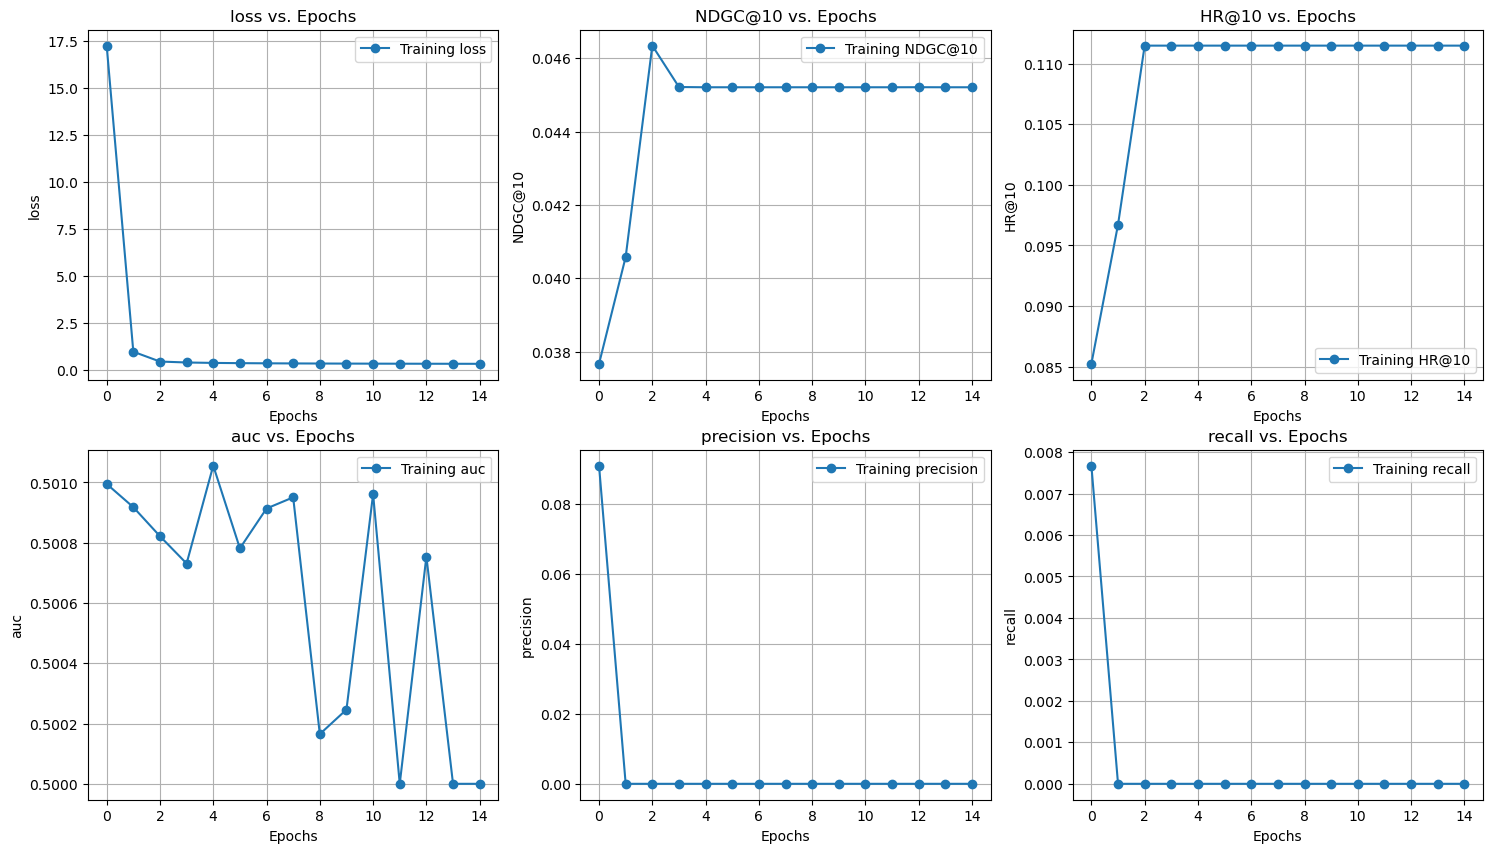

Best trial: 5. Best value: 0.501423:  40%|████      | 8/20 [10:29<15:39, 78.29s/it]

[I 2025-01-22 07:27:54,439] Trial 7 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 31, 'latent_dim_mlp': 45, 'embeding_l2_mf': 0.0317469854838789, 'embeding_l2_mlp': 0.03036943415316229, 'mlp_layers_num': 5, 'mlp_layers_neurons': 10, 'mlp_l2': 0.04594995213501472}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:27:54.877404: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:27:54.877439: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:27:54.877491: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:27:54.877512: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:27:57.080517: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:27:57.080551: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:27:57.080607: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:27:57.258421: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:27:57.305048: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:27:57.322609: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:27:57.428708: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072754/train/plugins/profile/2025_01_22_07_27_57
2025-01-22 07:27:57.498433: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-072754/train/plugins/profile/2025_01_22_07_27_57/computer.trace.json.gz
2025-01-22 07:27:57.551311: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-072754/train/plugins/profile/2025_01_22_07_27_57
2025-01-22 07:27:57.556010: I tensorflow/core/pro

Epoch 13: Early stopping triggered.


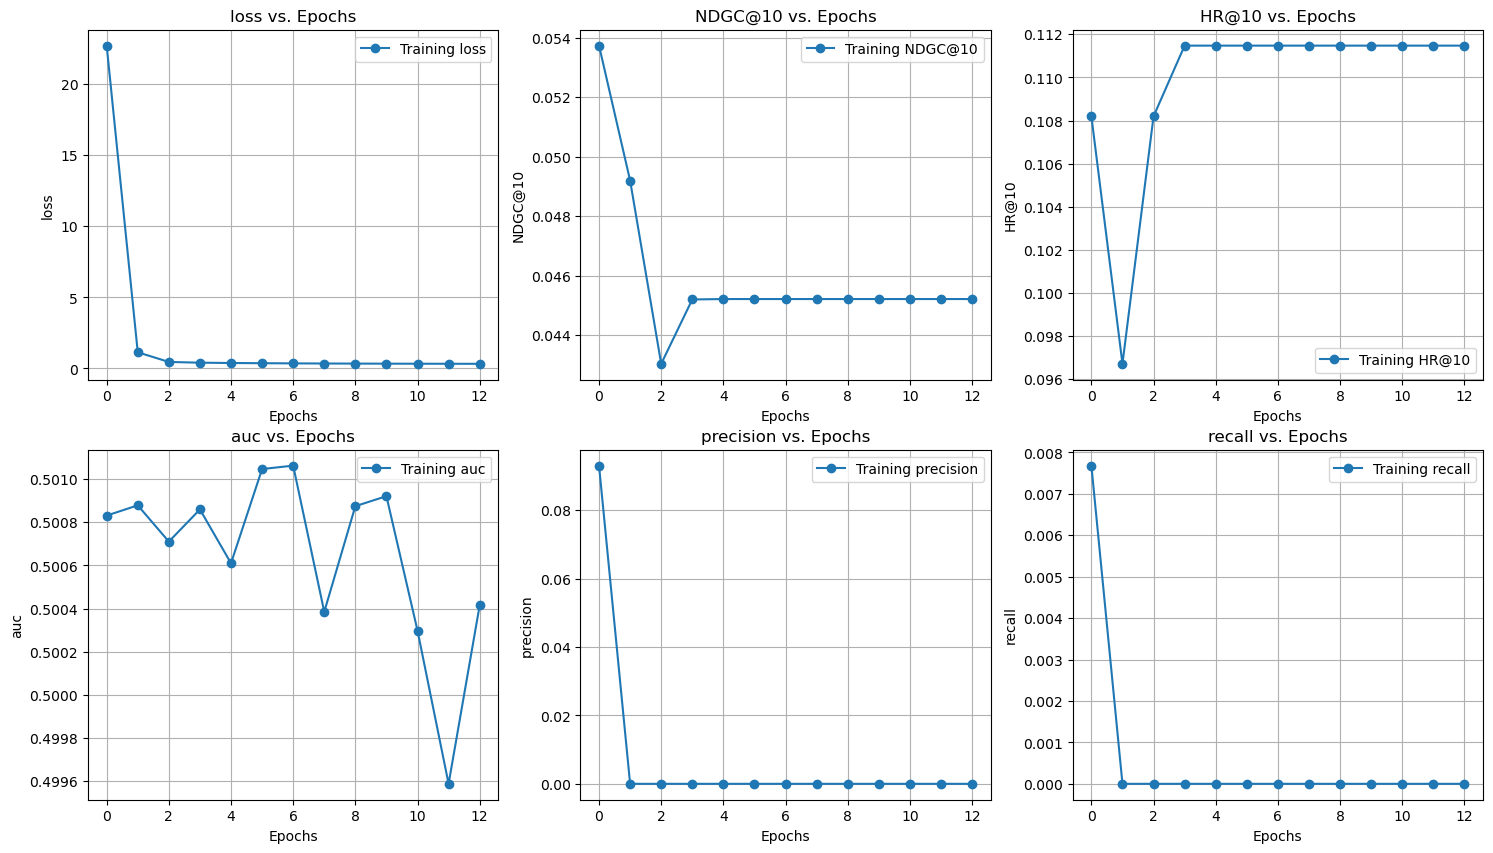

Best trial: 5. Best value: 0.501423:  45%|████▌     | 9/20 [11:25<13:05, 71.45s/it]

[I 2025-01-22 07:28:50,874] Trial 8 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 30, 'latent_dim_mlp': 27, 'embeding_l2_mf': 0.026788379869653434, 'embeding_l2_mlp': 0.085859375212105, 'mlp_layers_num': 6, 'mlp_layers_neurons': 20, 'mlp_l2': 0.09591737657234109}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:28:51.381182: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:28:51.381211: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:28:51.381272: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:28:51.381294: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:28:53.511365: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:28:53.511395: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:28:53.511440: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Epoch 15: Early stopping triggered.


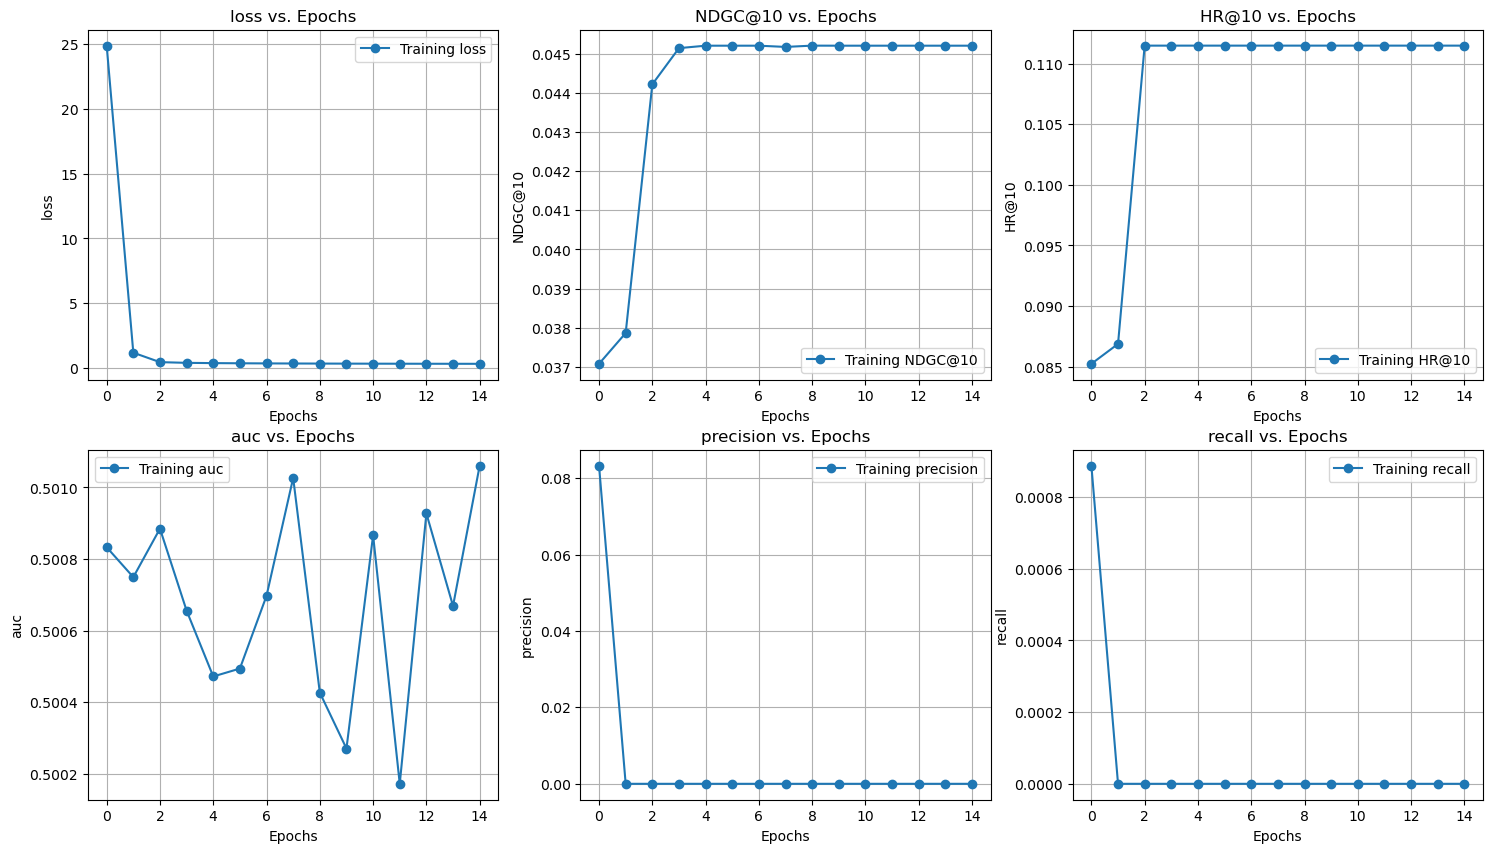

Best trial: 5. Best value: 0.501423:  50%|█████     | 10/20 [12:44<12:18, 73.83s/it]

[I 2025-01-22 07:30:10,041] Trial 9 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 103, 'latent_dim_mlp': 59, 'embeding_l2_mf': 0.025700333776330256, 'embeding_l2_mlp': 0.01340284040972517, 'mlp_layers_num': 8, 'mlp_layers_neurons': 6, 'mlp_l2': 0.028894628935349054}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:30:10.502674: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:30:10.502712: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:30:10.502760: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:30:10.502779: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:30:12.251261: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:30:12.251293: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:30:12.251343: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:30:12.394101: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:30:12.432838: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:30:12.450932: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:30:12.539340: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073010/train/plugins/profile/2025_01_22_07_30_12
2025-01-22 07:30:12.597891: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-073010/train/plugins/profile/2025_01_22_07_30_12/computer.trace.json.gz
2025-01-22 07:30:12.642716: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073010/train/plugins/profile/2025_01_22_07_30_12
2025-01-22 07:30:12.646060: I tensorflow/core/pro

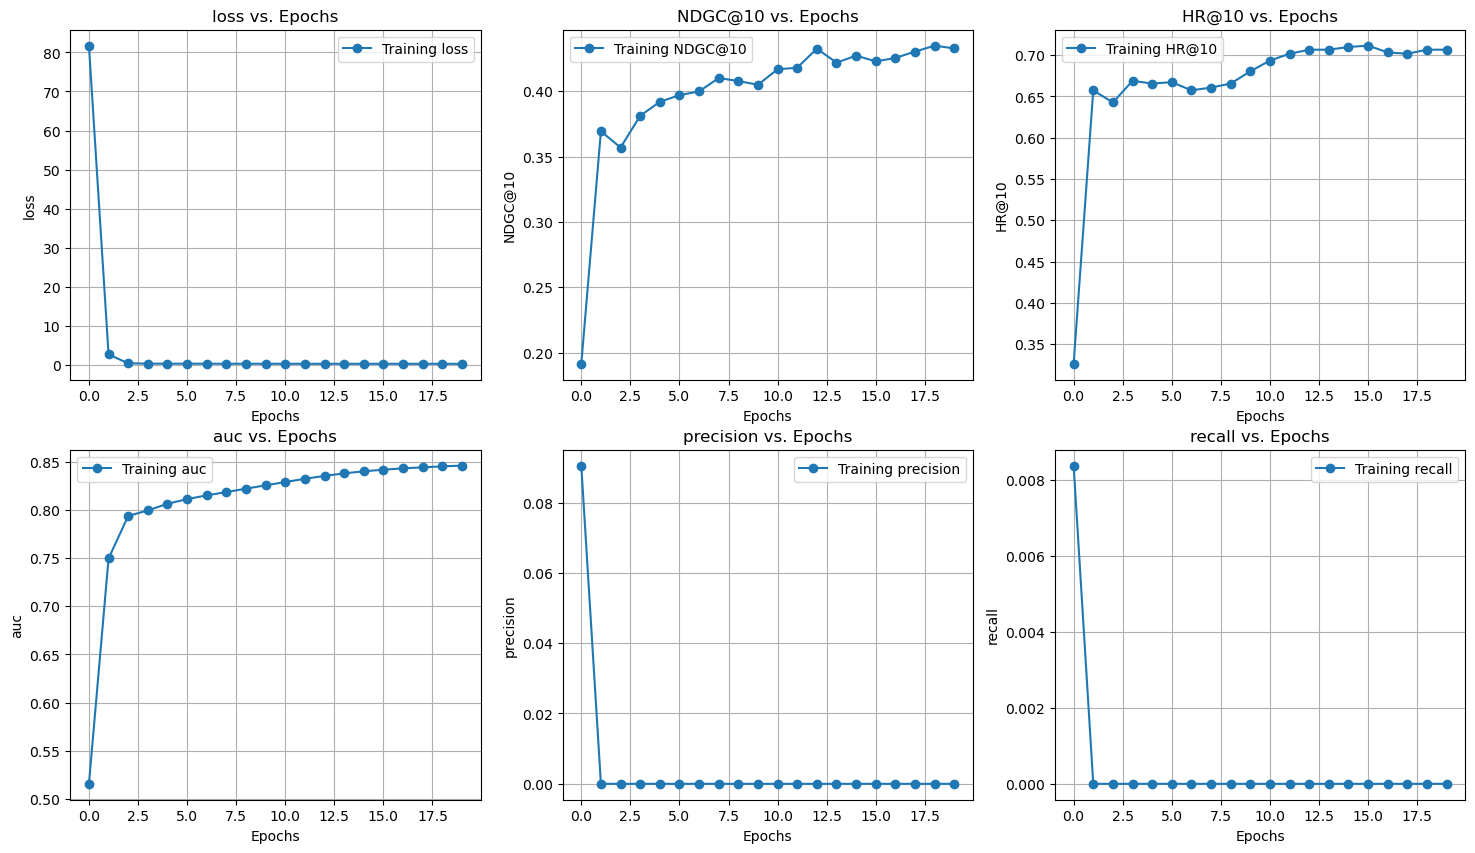

Best trial: 5. Best value: 0.501423:  55%|█████▌    | 11/20 [14:36<12:48, 85.44s/it]

[I 2025-01-22 07:32:01,791] Trial 10 finished with value: 0.4327142810733759 and parameters: {'latent_dim_mf': 65, 'latent_dim_mlp': 122, 'embeding_l2_mf': 0.052464531327511194, 'embeding_l2_mlp': 0.06615473549288502, 'mlp_layers_num': 3, 'mlp_layers_neurons': 32, 'mlp_l2': 0.001968825591659633}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:32:02.376346: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:32:02.376386: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:32:02.376445: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:32:02.376469: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:32:04.574116: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:32:04.574150: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:32:04.574205: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:32:04.757808: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:32:04.805077: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:32:04.825389: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:32:04.921280: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073202/train/plugins/profile/2025_01_22_07_32_04
2025-01-22 07:32:04.983305: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-073202/train/plugins/profile/2025_01_22_07_32_04/computer.trace.json.gz
2025-01-22 07:32:05.036623: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073202/train/plugins/profile/2025_01_22_07_32_04
2025-01-22 07:32:05.040403: I tensorflow/core/pro

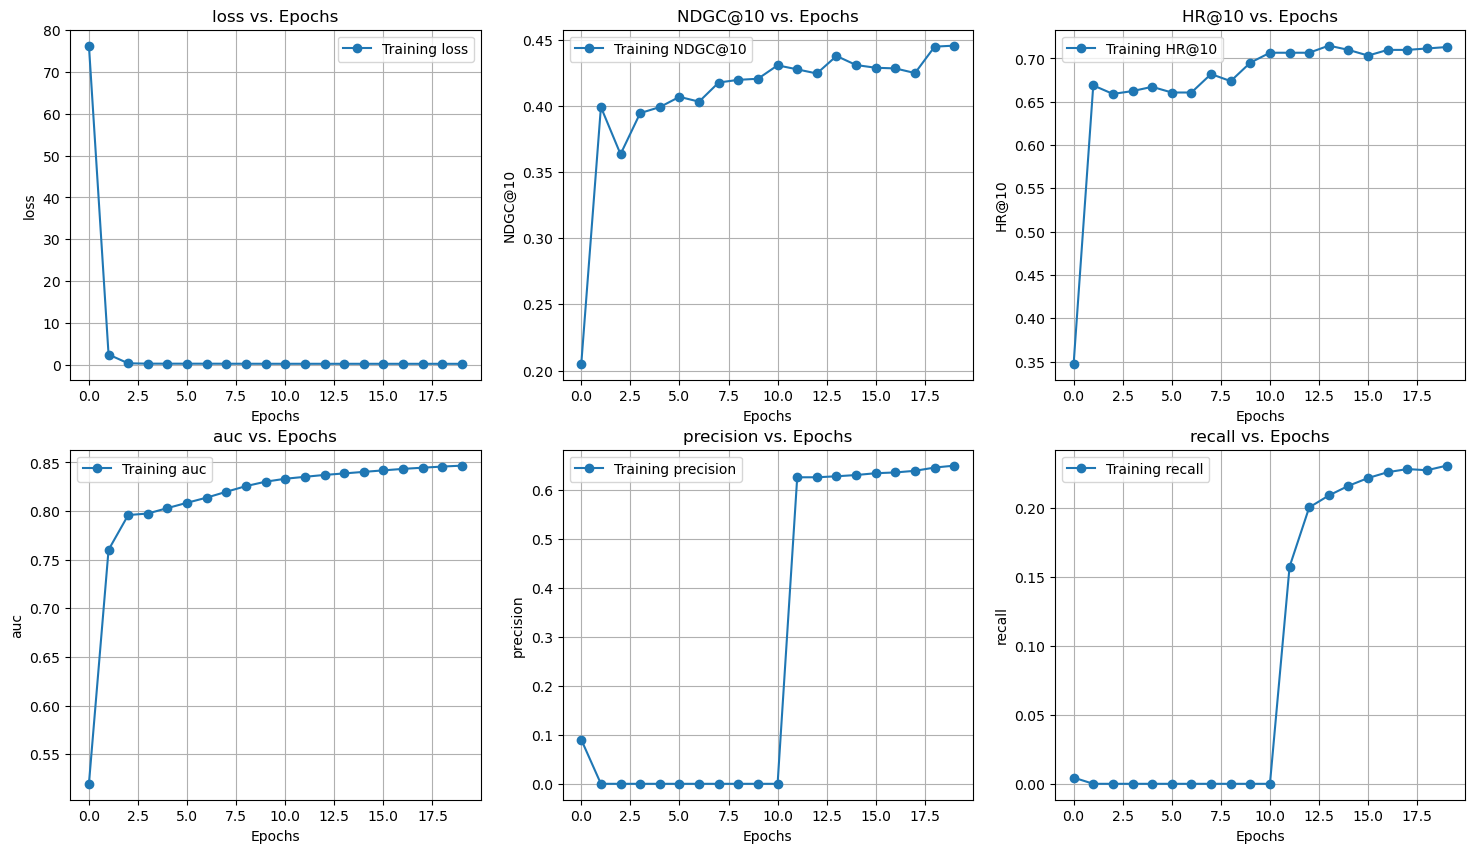

Best trial: 5. Best value: 0.501423:  60%|██████    | 12/20 [16:23<12:15, 91.97s/it]

[I 2025-01-22 07:33:48,669] Trial 11 finished with value: 0.4455318309097215 and parameters: {'latent_dim_mf': 60, 'latent_dim_mlp': 128, 'embeding_l2_mf': 0.05037173132382124, 'embeding_l2_mlp': 0.06028676122511181, 'mlp_layers_num': 3, 'mlp_layers_neurons': 32, 'mlp_l2': 0.00012322181374889527}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:33:49.213521: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:33:49.213551: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:33:49.213597: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:33:49.213615: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:33:51.978511: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:33:51.978547: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:33:51.978605: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Epoch 20: Early stopping triggered.


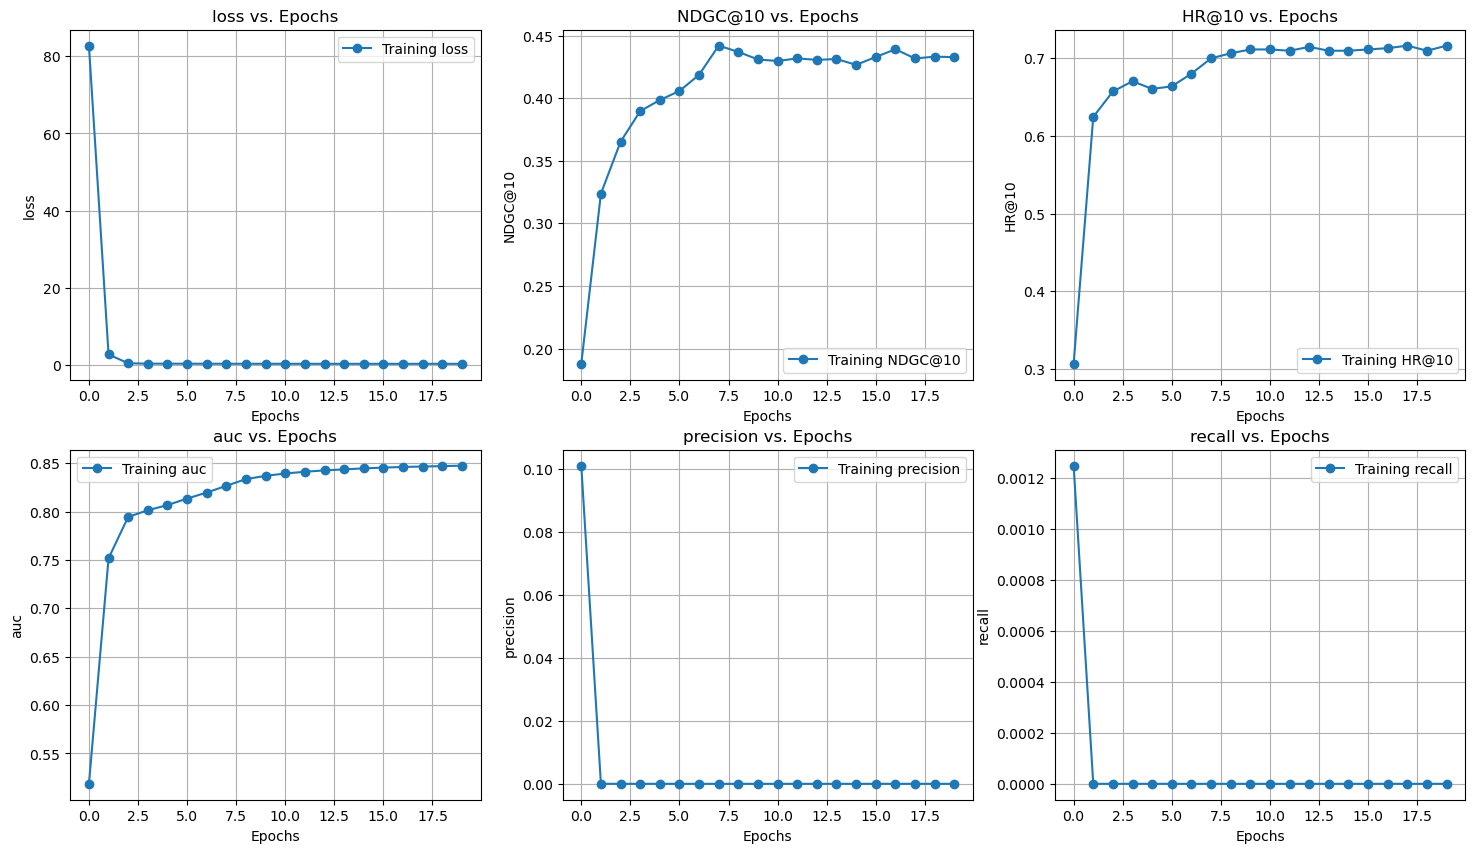

Best trial: 5. Best value: 0.501423:  65%|██████▌   | 13/20 [18:02<10:58, 94.14s/it]

[I 2025-01-22 07:35:27,827] Trial 12 finished with value: 0.432858447792541 and parameters: {'latent_dim_mf': 51, 'latent_dim_mlp': 128, 'embeding_l2_mf': 0.05288356170467414, 'embeding_l2_mlp': 0.07002629285135516, 'mlp_layers_num': 3, 'mlp_layers_neurons': 32, 'mlp_l2': 0.0036419648764465405}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:35:28.325575: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:35:28.325605: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:35:28.325652: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:35:28.325670: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:35:30.032147: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:35:30.032176: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:35:30.032221: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:35:30.167637: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:35:30.207095: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:35:30.223808: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:35:30.313129: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073528/train/plugins/profile/2025_01_22_07_35_30
2025-01-22 07:35:30.372301: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-073528/train/plugins/profile/2025_01_22_07_35_30/computer.trace.json.gz
2025-01-22 07:35:30.420633: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073528/train/plugins/profile/2025_01_22_07_35_30
2025-01-22 07:35:30.425669: I tensorflow/core/pro

Epoch 15: Early stopping triggered.


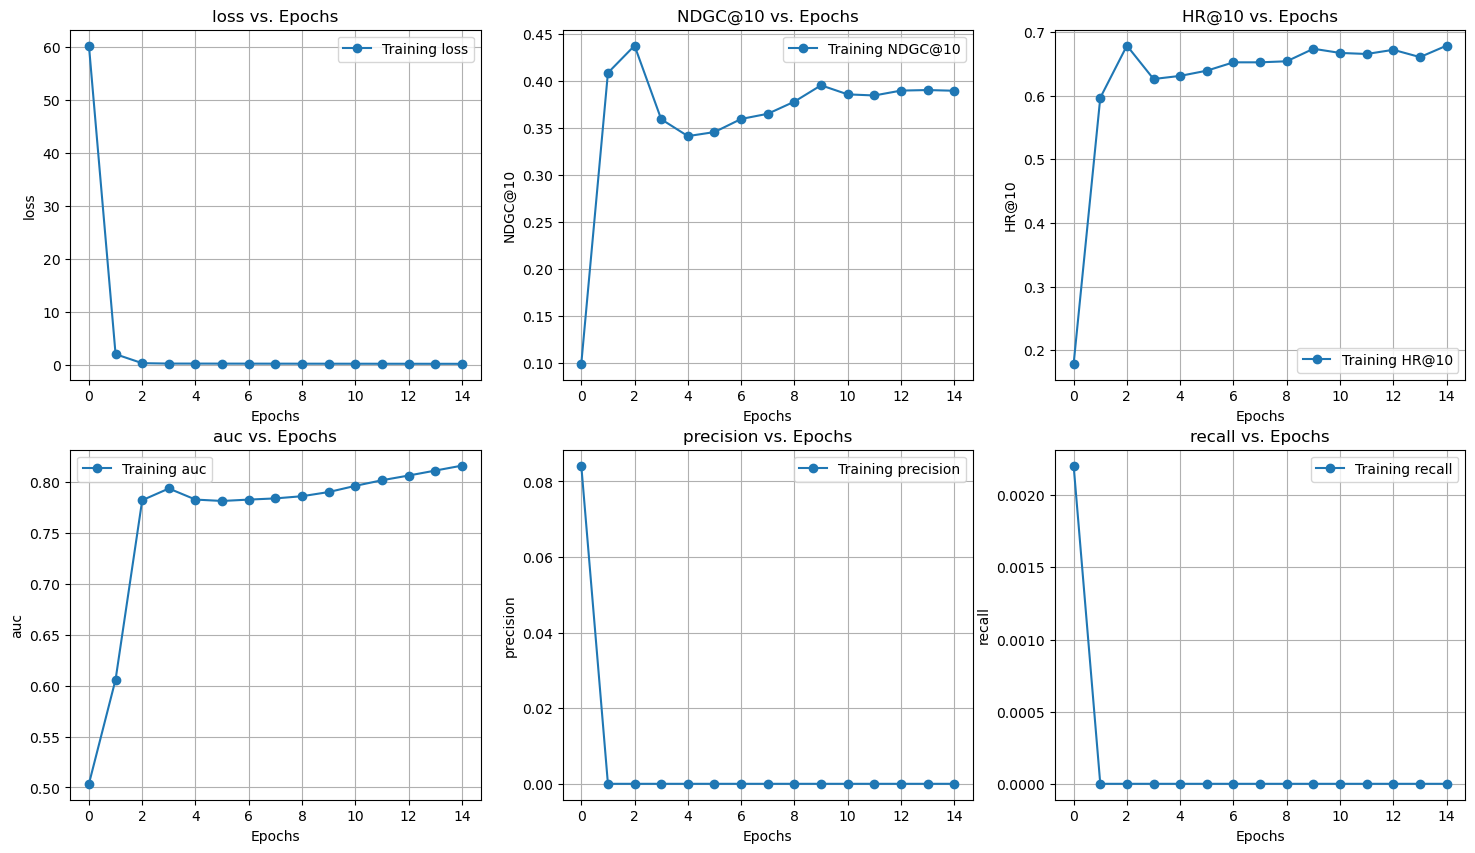

Best trial: 5. Best value: 0.501423:  70%|███████   | 14/20 [19:08<08:33, 85.57s/it]

[I 2025-01-22 07:36:33,588] Trial 13 finished with value: 0.38931286193799464 and parameters: {'latent_dim_mf': 9, 'latent_dim_mlp': 99, 'embeding_l2_mf': 0.06873942183647945, 'embeding_l2_mlp': 0.07902242576605306, 'mlp_layers_num': 2, 'mlp_layers_neurons': 26, 'mlp_l2': 0.01943624271353539}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:36:34.157629: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:36:34.157658: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:36:34.157711: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:36:34.157730: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:36:36.004983: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:36:36.005012: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:36:36.005057: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

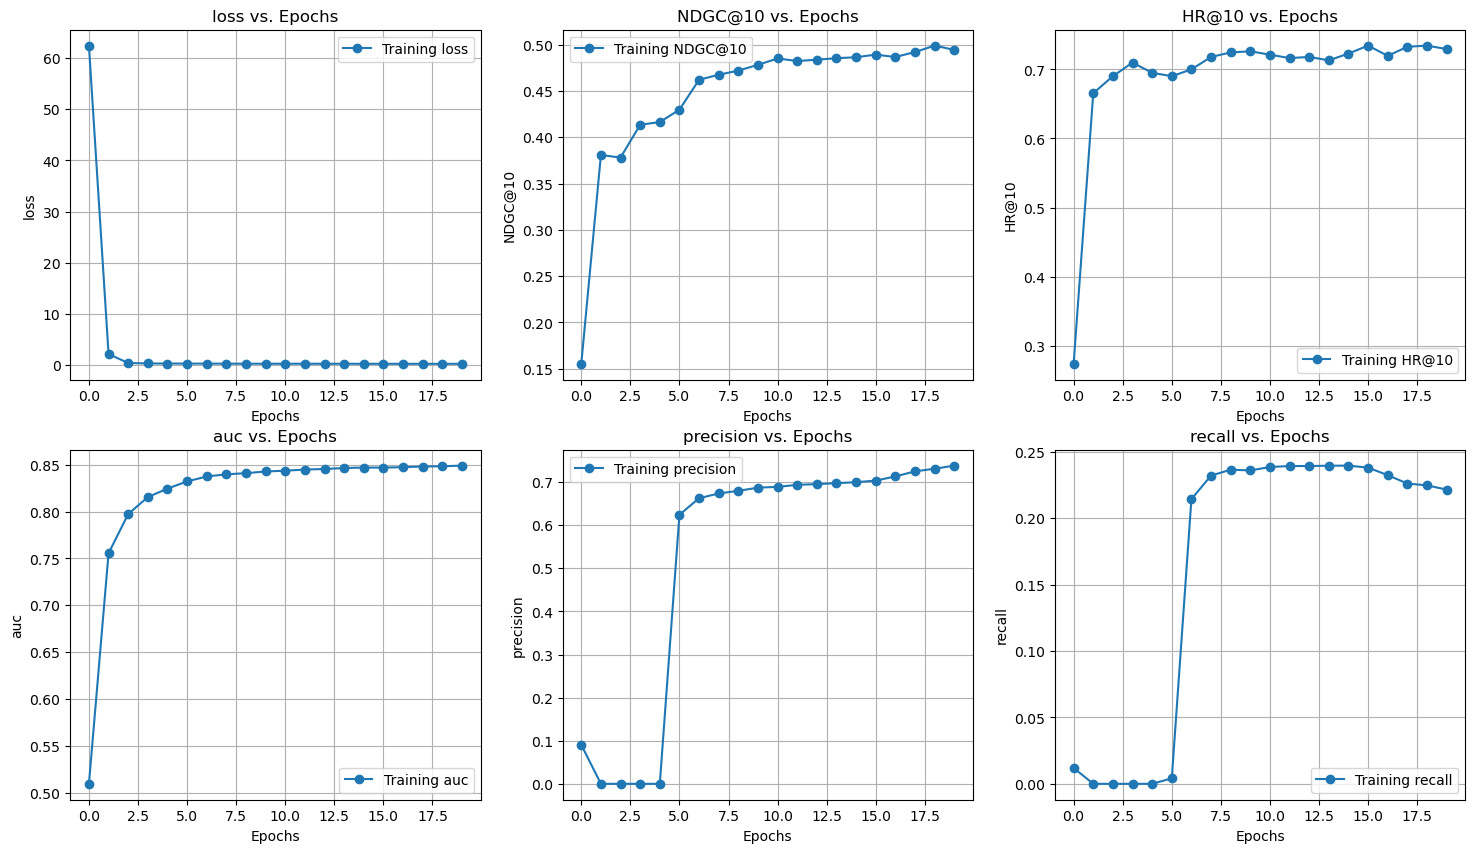

Best trial: 5. Best value: 0.501423:  75%|███████▌  | 15/20 [20:36<07:11, 86.21s/it]

[I 2025-01-22 07:38:01,316] Trial 14 finished with value: 0.4942445398888871 and parameters: {'latent_dim_mf': 80, 'latent_dim_mlp': 105, 'embeding_l2_mf': 0.04012555932690796, 'embeding_l2_mlp': 0.052806847994584336, 'mlp_layers_num': 4, 'mlp_layers_neurons': 26, 'mlp_l2': 0.016903507886613413}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:38:01.762055: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:38:01.762086: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:38:01.762132: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:38:01.762150: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:38:03.552305: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:38:03.552338: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:38:03.552389: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:38:03.687824: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:38:03.725497: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:38:03.739661: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:38:03.826638: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073801/train/plugins/profile/2025_01_22_07_38_03
2025-01-22 07:38:03.884449: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-073801/train/plugins/profile/2025_01_22_07_38_03/computer.trace.json.gz
2025-01-22 07:38:03.928259: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073801/train/plugins/profile/2025_01_22_07_38_03
2025-01-22 07:38:03.931722: I tensorflow/core/pro

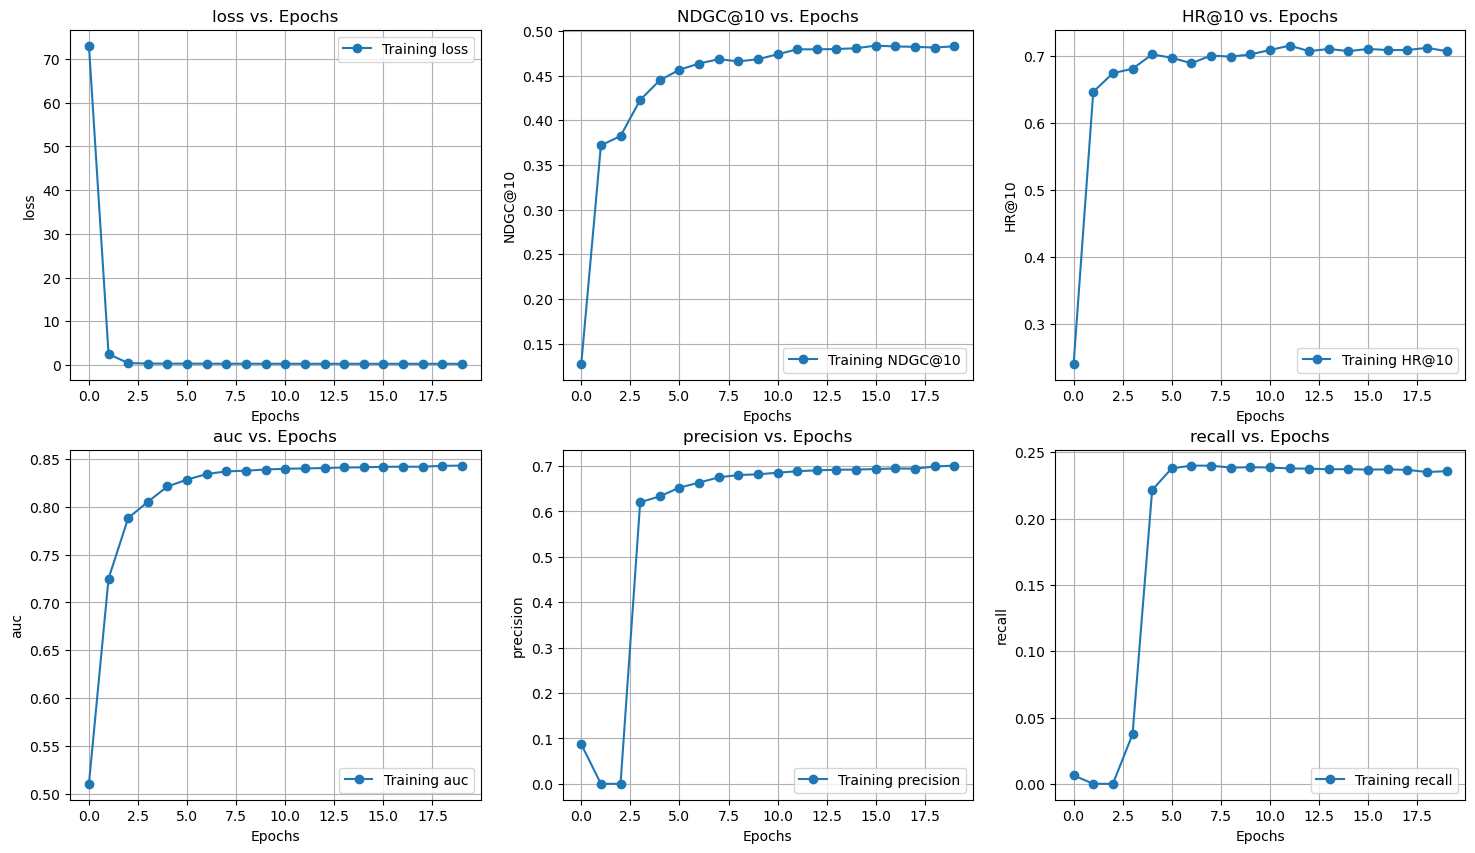

Best trial: 5. Best value: 0.501423:  80%|████████  | 16/20 [22:00<05:43, 85.77s/it]

[I 2025-01-22 07:39:26,053] Trial 15 finished with value: 0.48281441208265335 and parameters: {'latent_dim_mf': 84, 'latent_dim_mlp': 103, 'embeding_l2_mf': 0.0006417116724416333, 'embeding_l2_mlp': 0.09894900859660283, 'mlp_layers_num': 4, 'mlp_layers_neurons': 25, 'mlp_l2': 0.01932081810607042}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:39:26.425065: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:39:26.425096: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:39:26.425145: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:39:26.425163: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:39:28.244013: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:39:28.244047: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:39:28.244099: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:39:28.384910: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:39:28.423556: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:39:28.439120: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:39:28.528096: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073926/train/plugins/profile/2025_01_22_07_39_28
2025-01-22 07:39:28.585571: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-073926/train/plugins/profile/2025_01_22_07_39_28/computer.trace.json.gz
2025-01-22 07:39:28.630658: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-073926/train/plugins/profile/2025_01_22_07_39_28
2025-01-22 07:39:28.634793: I tensorflow/core/pro

Epoch 20: Early stopping triggered.


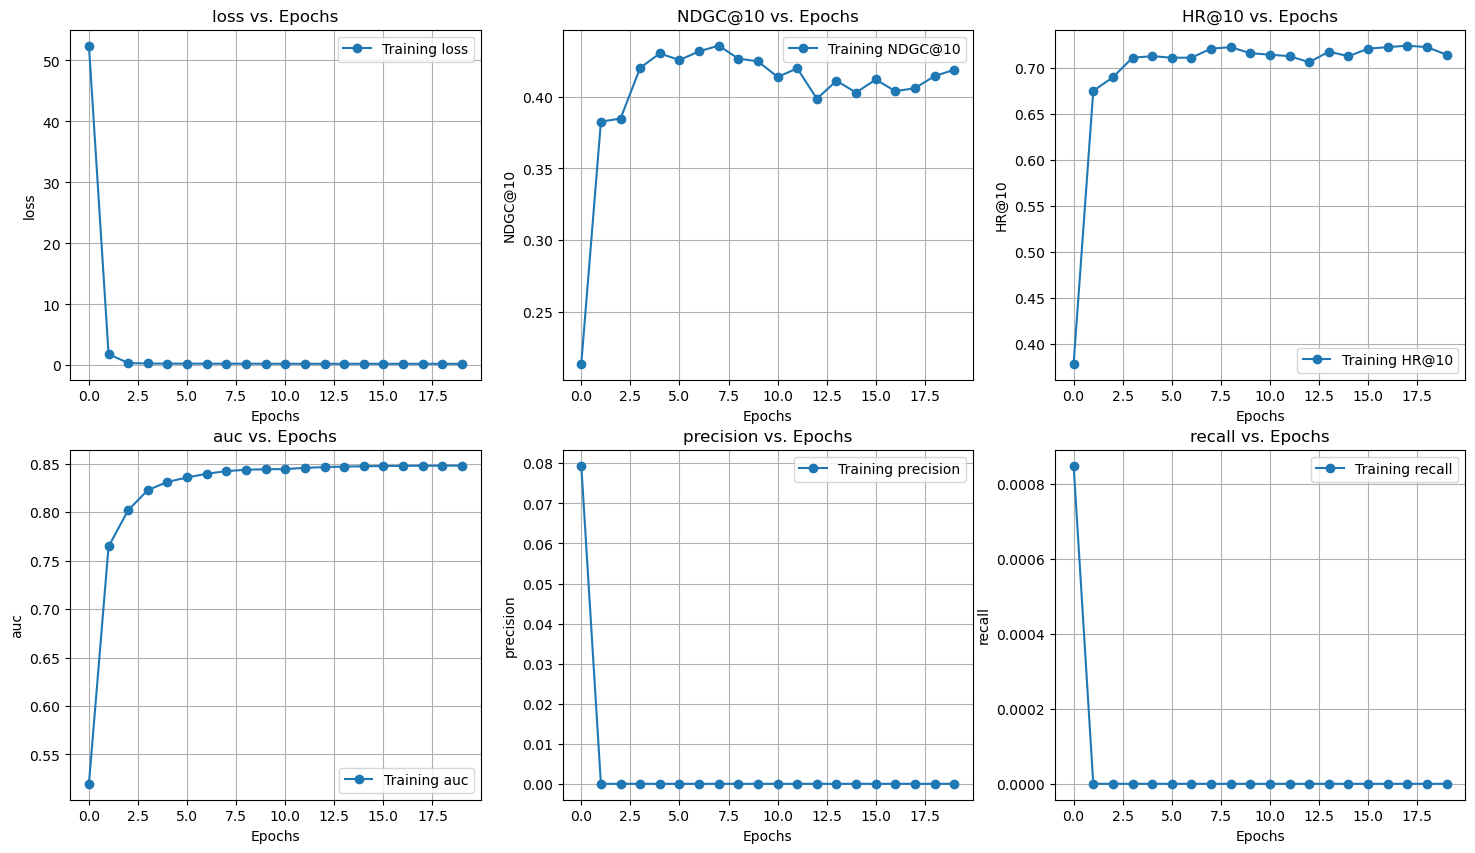

Best trial: 5. Best value: 0.501423:  85%|████████▌ | 17/20 [23:46<04:35, 91.75s/it]

[I 2025-01-22 07:41:11,705] Trial 16 finished with value: 0.4188812233903569 and parameters: {'latent_dim_mf': 84, 'latent_dim_mlp': 84, 'embeding_l2_mf': 0.03678129506455965, 'embeding_l2_mlp': 0.050832598652799224, 'mlp_layers_num': 4, 'mlp_layers_neurons': 26, 'mlp_l2': 0.016387335368550138}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:41:12.426054: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:41:12.426084: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:41:12.426132: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:41:12.426150: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:41:14.832013: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:41:14.832051: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:41:14.832104: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:41:15.017860: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:41:15.058832: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:41:15.077037: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:41:15.167631: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-074112/train/plugins/profile/2025_01_22_07_41_15
2025-01-22 07:41:15.227348: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-074112/train/plugins/profile/2025_01_22_07_41_15/computer.trace.json.gz
2025-01-22 07:41:15.279958: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-074112/train/plugins/profile/2025_01_22_07_41_15
2025-01-22 07:41:15.284394: I tensorflow/core/pro

Epoch 14: Early stopping triggered.


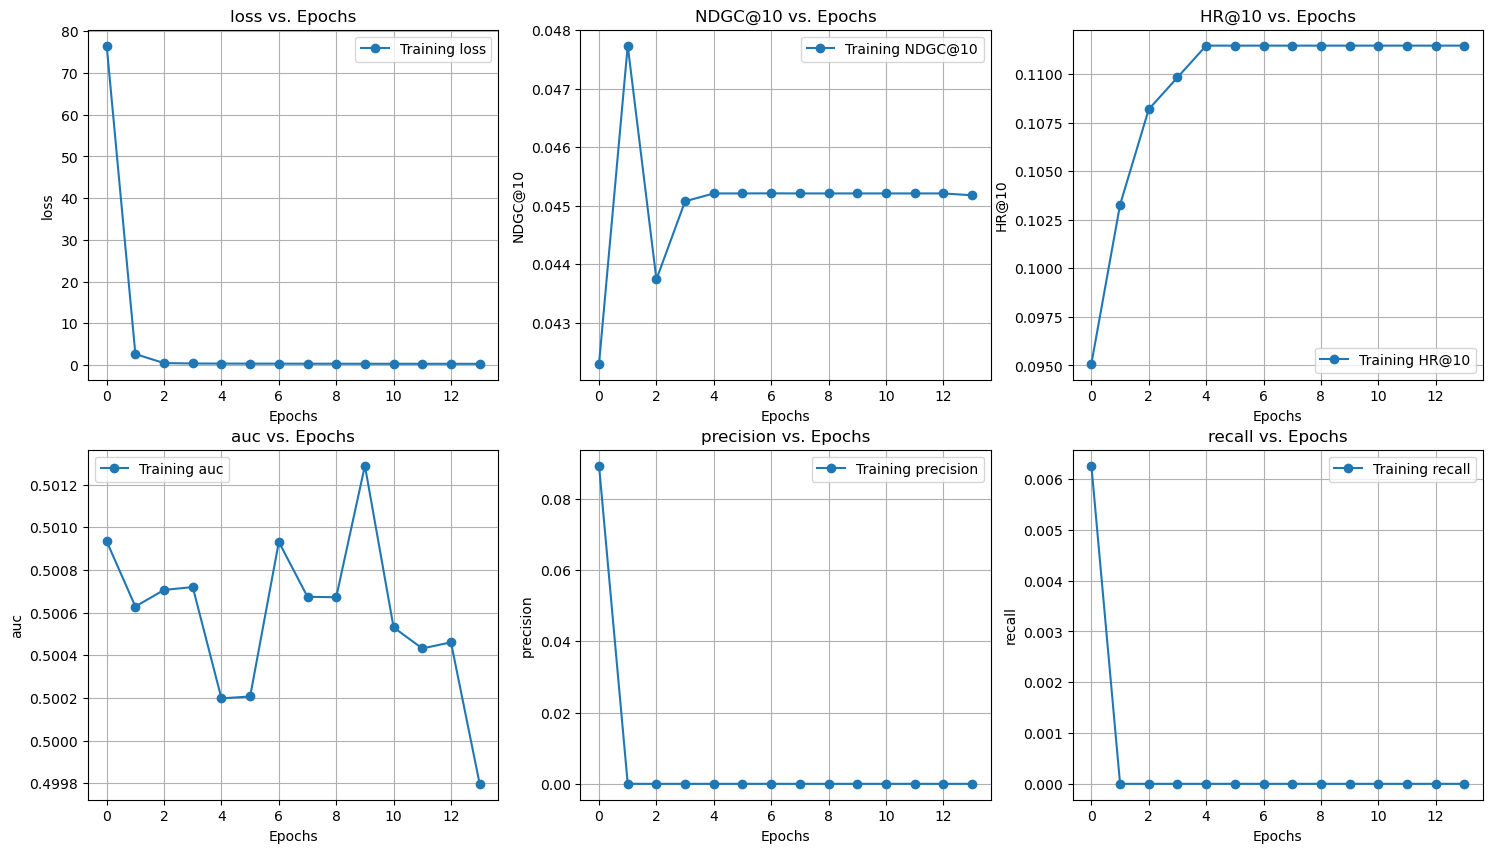

Best trial: 5. Best value: 0.501423:  90%|█████████ | 18/20 [25:20<03:04, 92.49s/it]

[I 2025-01-22 07:42:45,913] Trial 17 finished with value: 0.04517978203942554 and parameters: {'latent_dim_mf': 125, 'latent_dim_mlp': 110, 'embeding_l2_mf': 0.040409815000552185, 'embeding_l2_mlp': 0.05179383953087934, 'mlp_layers_num': 6, 'mlp_layers_neurons': 22, 'mlp_l2': 0.03168693133460684}. Best is trial 5 with value: 0.5014232784253373.


2025-01-22 07:42:46.415504: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:42:46.415533: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:42:46.415581: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:42:46.415598: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:42:48.631005: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:42:48.631046: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:42:48.631100: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 07:42:48.799590: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 07:42:48.835411: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 07:42:48.851318: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:42:48.933191: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-074246/train/plugins/profile/2025_01_22_07_42_48
2025-01-22 07:42:48.985713: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-074246/train/plugins/profile/2025_01_22_07_42_48/computer.trace.json.gz
2025-01-22 07:42:49.031908: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-074246/train/plugins/profile/2025_01_22_07_42_48
2025-01-22 07:42:49.035523: I tensorflow/core/pro

Epoch 20: Early stopping triggered.


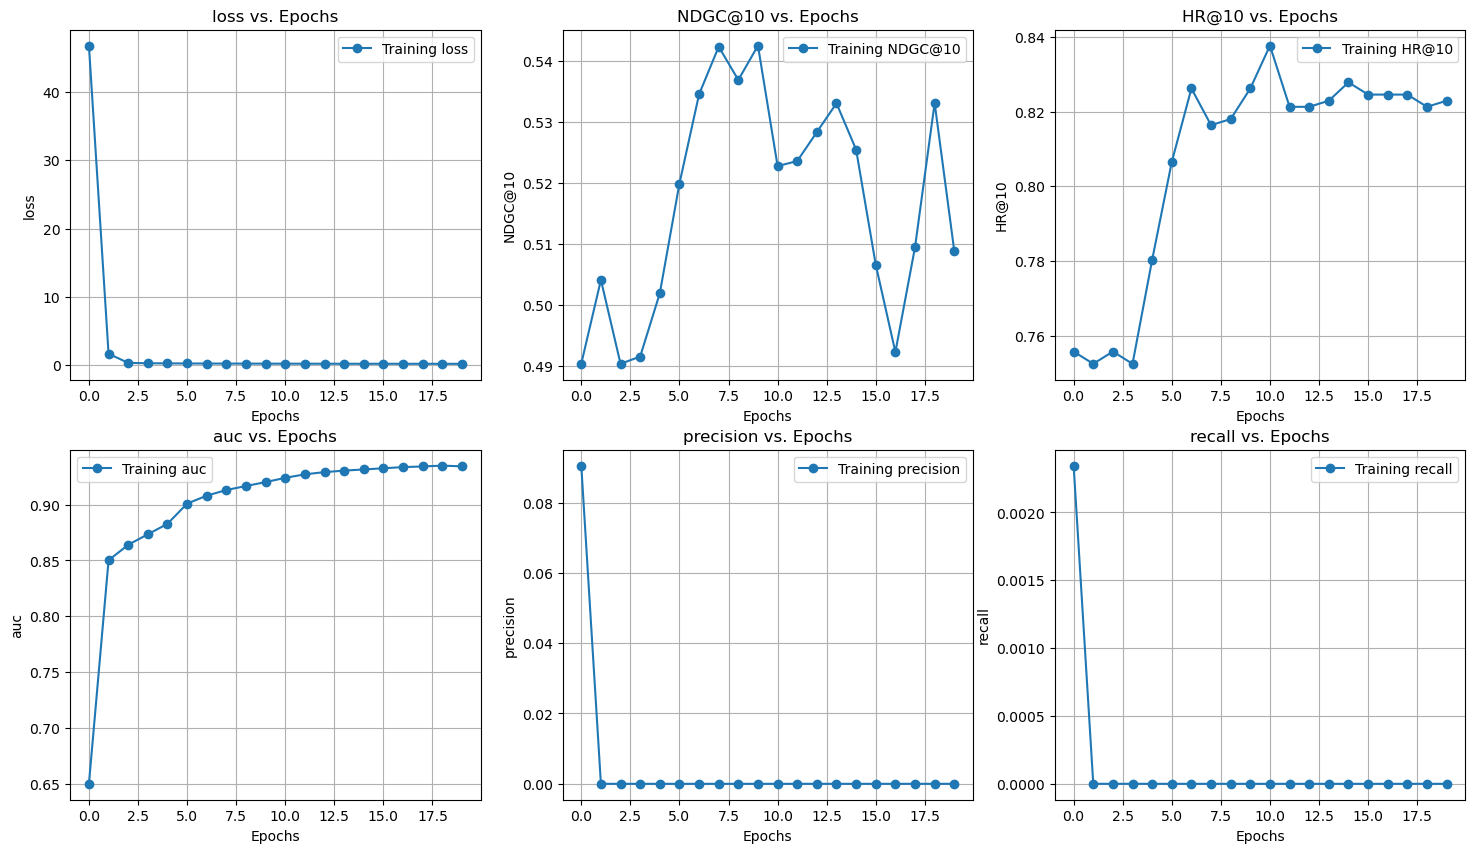

Best trial: 18. Best value: 0.508787:  95%|█████████▌| 19/20 [26:37<01:27, 87.83s/it]

[I 2025-01-22 07:44:02,893] Trial 18 finished with value: 0.5087873770712852 and parameters: {'latent_dim_mf': 93, 'latent_dim_mlp': 8, 'embeding_l2_mf': 0.07040089863700855, 'embeding_l2_mlp': 0.00013722927524390666, 'mlp_layers_num': 4, 'mlp_layers_neurons': 28, 'mlp_l2': 0.013525077950357532}. Best is trial 18 with value: 0.5087873770712852.


2025-01-22 07:44:03.297644: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:44:03.297674: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:44:03.297726: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 07:44:03.297743: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 07:44:05.622240: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 07:44:05.622271: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 07:44:05.622320: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Epoch 16: Early stopping triggered.


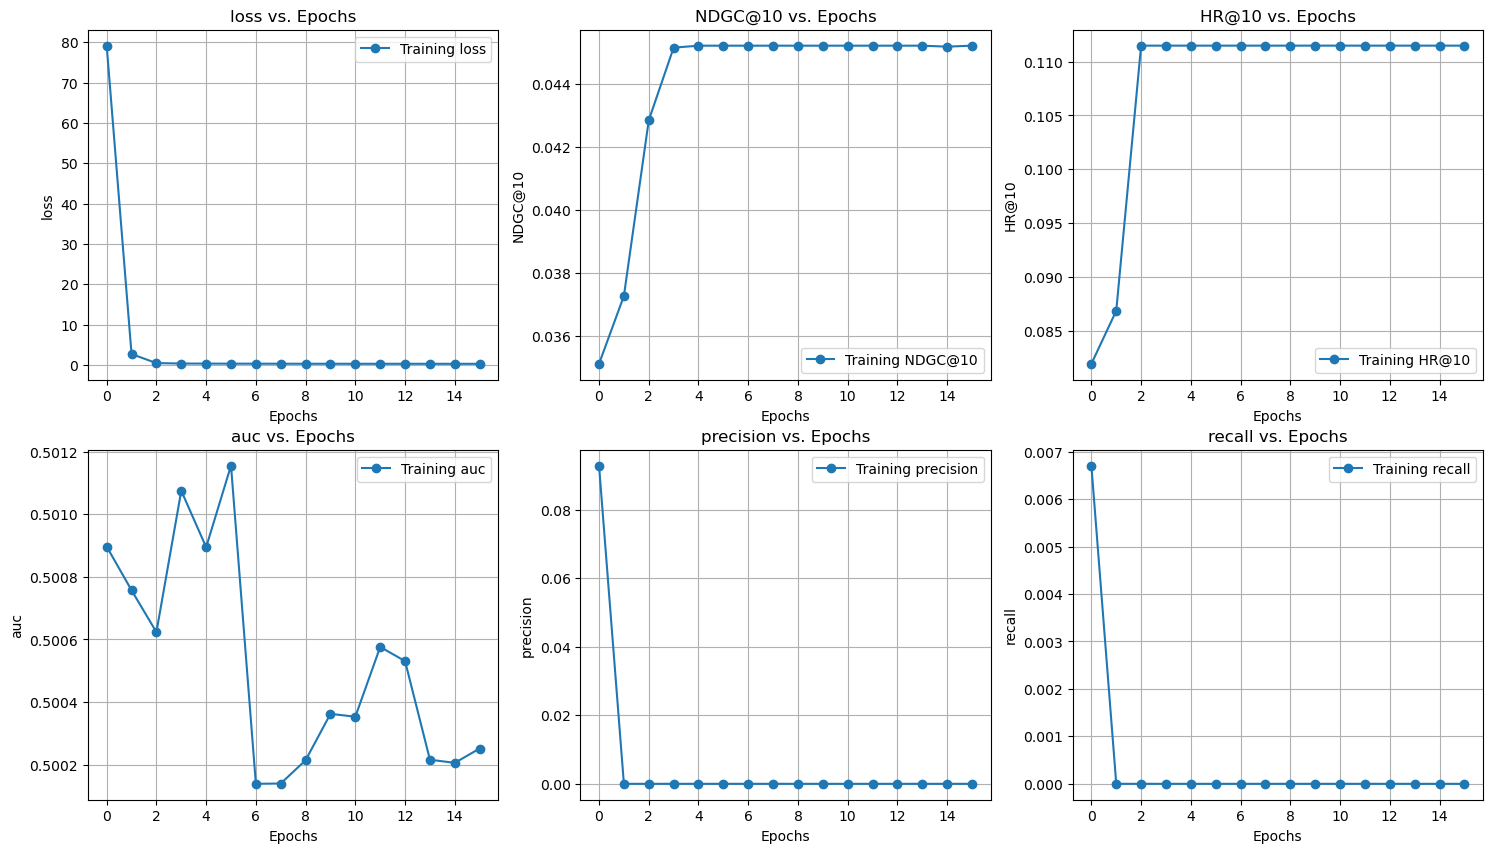

Best trial: 18. Best value: 0.508787: 100%|██████████| 20/20 [27:43<00:00, 83.16s/it]

[I 2025-01-22 07:45:08,346] Trial 19 finished with value: 0.04521273451500097 and parameters: {'latent_dim_mf': 117, 'latent_dim_mlp': 12, 'embeding_l2_mf': 0.09477646753596561, 'embeding_l2_mlp': 0.0012274156952779463, 'mlp_layers_num': 5, 'mlp_layers_neurons': 28, 'mlp_l2': 0.06218028496969103}. Best is trial 18 with value: 0.5087873770712852.


In [14]:
def objective(trial):
  model = create_model_NeuMF({
    "n_users": len(users_all),
    "n_items": len(items_all),
    
    "latent_dim_mf": trial.suggest_int('latent_dim_mf', 8, 128),
    "latent_dim_mlp": trial.suggest_int('latent_dim_mlp', 8, 128),
    "embeding_l2_mf": trial.suggest_float('embeding_l2_mf', 0.0, 0.1),
    "embeding_l2_mlp": trial.suggest_float('embeding_l2_mlp', 0.0, 0.1),
    
    "mlp_layers_num": trial.suggest_int('mlp_layers_num', 2, 8),
    "mlp_layers_neurons": trial.suggest_int('mlp_layers_neurons', 4, 32),
    "mlp_l2": trial.suggest_float('mlp_l2', 0.0, 0.1)
  })
  
  model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.AUC(name="auc"),
      tf.keras.metrics.Precision(name="precision"),
      tf.keras.metrics.Recall(name="recall"),
      tf.keras.metrics.TruePositives(name="tp"),
      tf.keras.metrics.FalsePositives(name="fp"),
      tf.keras.metrics.TrueNegatives(name="tn"),
      tf.keras.metrics.FalseNegatives(name="fn"),
    ],
  )
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=12, test_data=test_data)

  train_hist = model.fit(
    train_dataset,
    epochs=20,
    callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
    verbose=0
  ) 
  
  make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)

  return ndcg_score(earlyStoppingAtNDGC.valid_true, earlyStoppingAtNDGC.y_score, k=10)

study = optuna.create_study(direction='maximize', storage="sqlite:///op.db")
study.optimize(objective, n_trials=20, show_progress_bar=True)

## Zapisanie najleprzej architektury do pliku

In [19]:
import json

best_params = study.best_params
best_params["n_users"] = len(users_all)
best_params["n_items"] = len(items_all)
model = create_model_NeuMF(best_params)

model_json = model.to_json()
with open("model_architectures/NeuMF_hiper_params.json", "w") as json_file:
    json_file.write(json.dumps(best_params))

## Podsumowanie najlepszej architektury

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
MLP_User_Embedding (Embedding)  (None, 8)            4880        user_id[0][0]                    
__________________________________________________________________________________________________
MLP_Item_Embedding (Embedding)  (None, 8)            77792       item_id[0][0]                    
___________________________________________________________________________________________

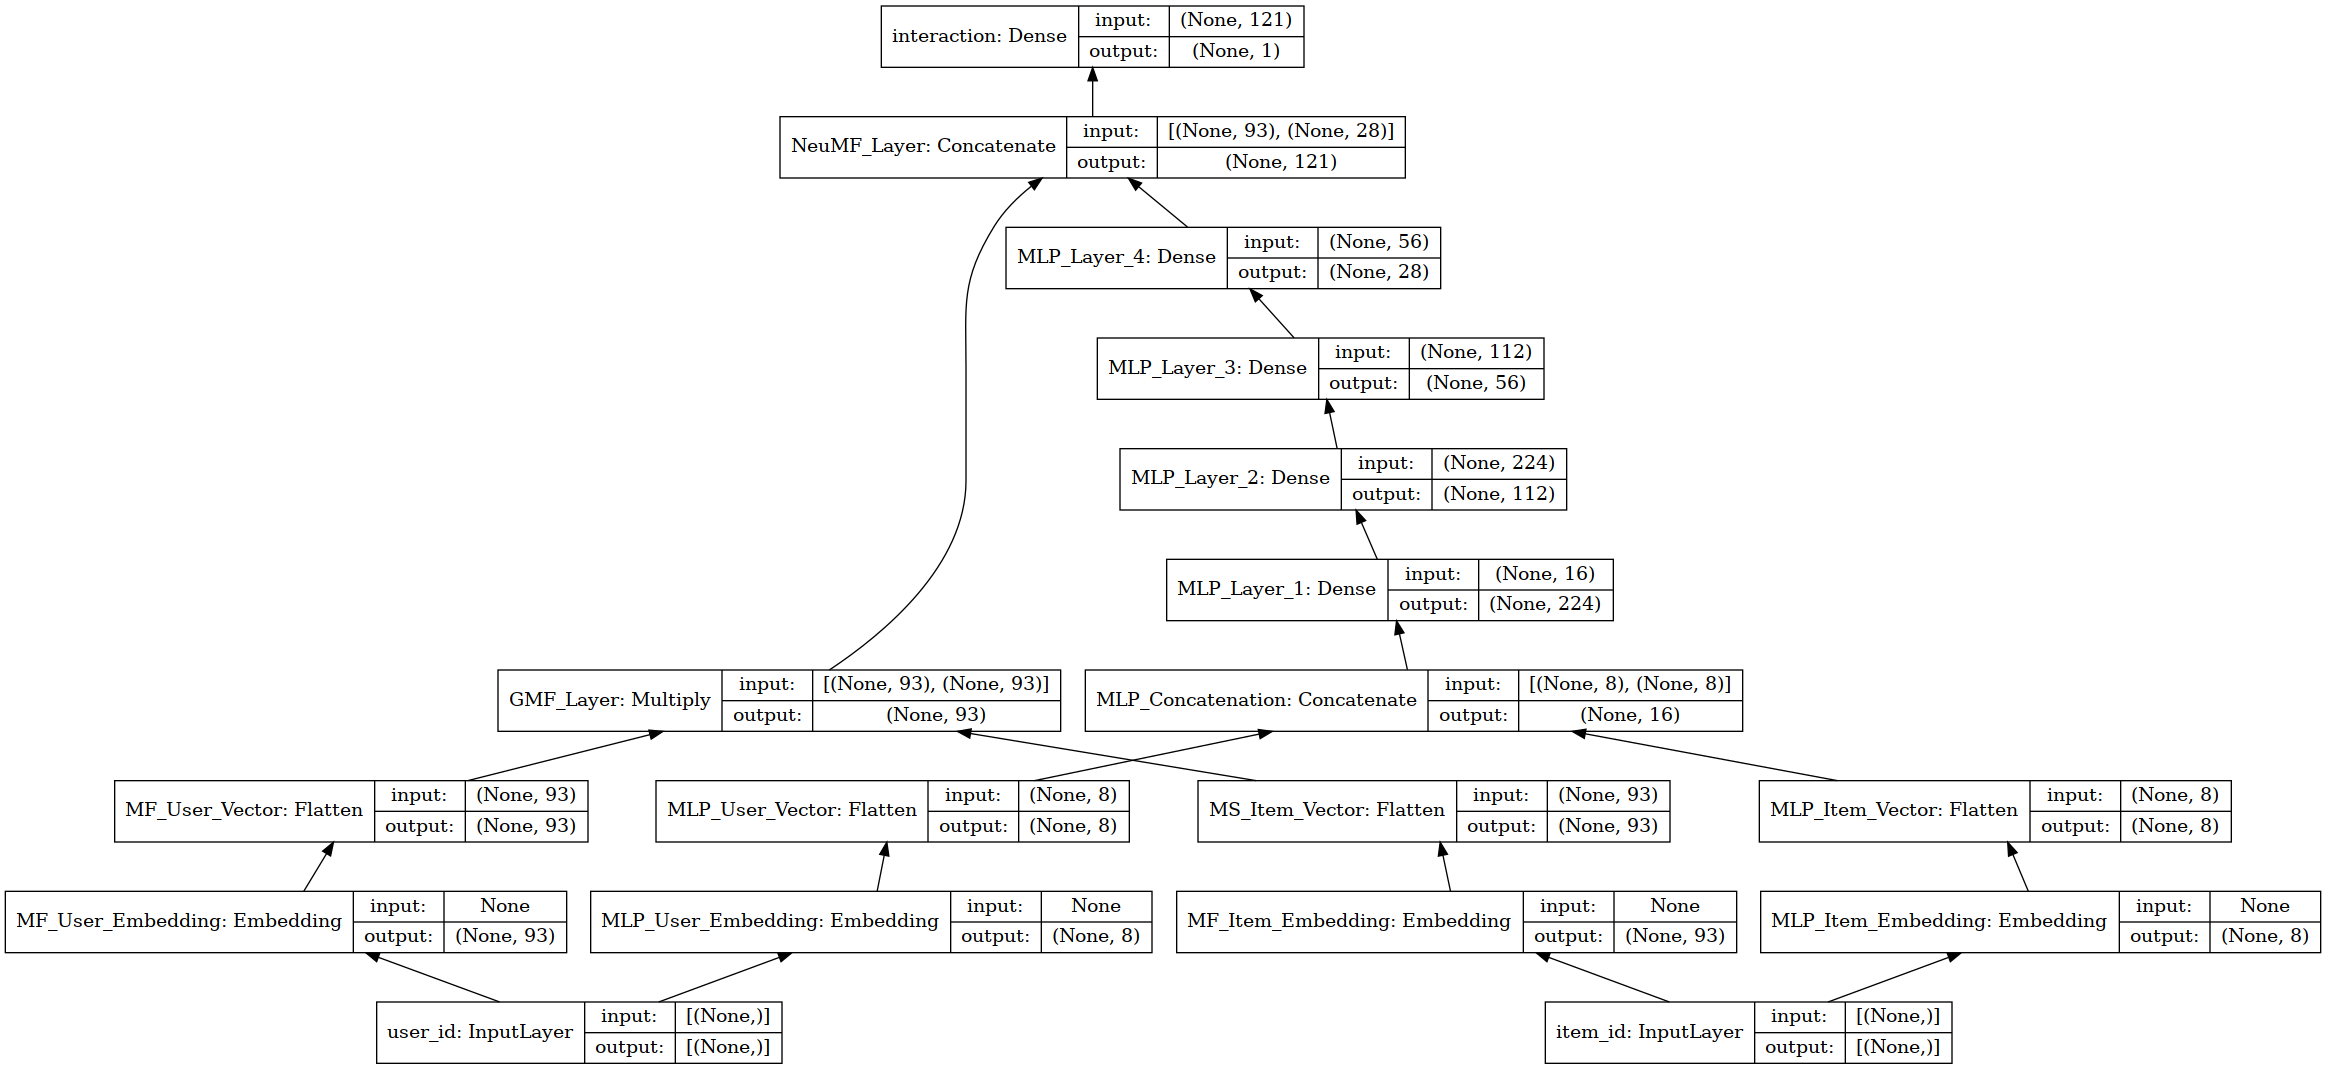

In [20]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="BT",)

In [21]:
make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)

NameError: name 'train_hist' is not defined

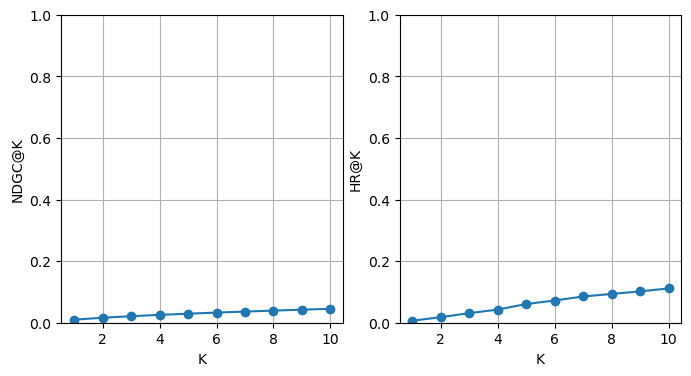

: 

In [22]:
make_metrics_vs_k_graphs(test_data)